In [ ]:
pip install statsmodels

In [ ]:
pip install pmdarima

In [ ]:
pip install arch

In [4]:
# Importing necessary packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('seaborn-darkgrid')
%matplotlib inline

# For time stamps
import matplotlib.dates as mdates
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model as ARCH
import pmdarima as pm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

### Covid data:

In [6]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'

covid_raw = pd.read_csv(url, sep = ',', parse_dates = ['date'])
covid_raw.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [7]:
covid_new = covid_raw[['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases']]

covid_new = covid_new.fillna(0) # fill NaN values as zeros
covid_new[['total_cases', 'new_cases']] = covid_new[['total_cases', 'new_cases']].astype(int) # converting to int

covid_new

,iso_code,continent,location,date,total_cases,new_cases
0,AFG,Asia,Afghanistan,2020-02-24,5,5
1,AFG,Asia,Afghanistan,2020-02-25,5,0
2,AFG,Asia,Afghanistan,2020-02-26,5,0
3,AFG,Asia,Afghanistan,2020-02-27,5,0
4,AFG,Asia,Afghanistan,2020-02-28,5,0
...,...,...,...,...,...,...
189950,ZWE,Africa,Zimbabwe,2022-05-24,250929,227
189951,ZWE,Africa,Zimbabwe,2022-05-25,251228,299
189952,ZWE,Africa,Zimbabwe,2022-05-26,251646,418
189953,ZWE,Africa,Zimbabwe,2022-05-27,251959,313


### Russia:

In [8]:
# Extracting Russia:
df_Russia = covid_new[covid_new['iso_code'].isin(['RUS'])]
df_Russia.index = np.arange(0, len(df_Russia)) # new indexing
df_Russia['ma_cases'] = df_Russia['new_cases'].transform(lambda x: x.rolling(window = 7, min_periods = 1, center = False).mean()) # crating average 7-day column
df_Russia['date'] = pd.to_datetime(df_Russia['date'])
df_Russia

,iso_code,continent,location,date,total_cases,new_cases,ma_cases
0,RUS,Europe,Russia,2020-01-31,2,2,2.000000
1,RUS,Europe,Russia,2020-02-01,2,0,1.000000
2,RUS,Europe,Russia,2020-02-02,2,0,0.666667
3,RUS,Europe,Russia,2020-02-03,2,0,0.500000
4,RUS,Europe,Russia,2020-02-04,2,0,0.400000
...,...,...,...,...,...,...,...
844,RUS,Europe,Russia,2022-05-24,18034423,3704,4561.428571
845,RUS,Europe,Russia,2022-05-25,18038920,4497,4535.857143
846,RUS,Europe,Russia,2022-05-26,18043539,4619,4502.857143
847,RUS,Europe,Russia,2022-05-27,18048085,4546,4435.142857


### Serbia:

In [9]:
# Extracting Serbia:
df_Serbia = covid_new[covid_new['iso_code'].isin(['SRB'])]
df_Serbia.index = np.arange(0, len(df_Serbia)) # new indexing
df_Serbia['ma_cases'] = df_Serbia['new_cases'].transform(lambda x: x.rolling(window = 7, min_periods = 1, center = False).mean()) # crating average 7-day column
df_Serbia['date'] = pd.to_datetime(df_Serbia['date'])
df_Serbia

,iso_code,continent,location,date,total_cases,new_cases,ma_cases
0,SRB,Europe,Serbia,2020-02-26,0,0,0.000000
1,SRB,Europe,Serbia,2020-02-27,0,0,0.000000
2,SRB,Europe,Serbia,2020-02-28,0,0,0.000000
3,SRB,Europe,Serbia,2020-02-29,0,0,0.000000
4,SRB,Europe,Serbia,2020-03-01,0,0,0.000000
...,...,...,...,...,...,...,...
818,SRB,Europe,Serbia,2022-05-24,2015711,329,298.428571
819,SRB,Europe,Serbia,2022-05-25,2016002,291,288.428571
820,SRB,Europe,Serbia,2022-05-26,2016266,264,278.428571
821,SRB,Europe,Serbia,2022-05-27,2016576,310,274.714286


### Sweden:

In [10]:
# Extracting Sweden:
df_Sweden = covid_new[covid_new['iso_code'].isin(['SWE'])]
df_Sweden.index = np.arange(0, len(df_Sweden)) # new indexing
df_Sweden['ma_cases'] = df_Sweden['new_cases'].transform(lambda x: x.rolling(window = 7, min_periods = 1, center = False).mean()) # crating average 7-day column
df_Sweden['date'] = pd.to_datetime(df_Sweden['date'])
df_Sweden

,iso_code,continent,location,date,total_cases,new_cases,ma_cases
0,SWE,Europe,Sweden,2020-02-01,1,1,1.000000
1,SWE,Europe,Sweden,2020-02-02,1,0,0.500000
2,SWE,Europe,Sweden,2020-02-03,1,0,0.333333
3,SWE,Europe,Sweden,2020-02-04,1,0,0.250000
4,SWE,Europe,Sweden,2020-02-05,1,0,0.200000
...,...,...,...,...,...,...,...
843,SWE,Europe,Sweden,2022-05-24,2506607,0,244.714286
844,SWE,Europe,Sweden,2022-05-25,2507948,1341,436.285714
845,SWE,Europe,Sweden,2022-05-26,2507948,0,191.571429
846,SWE,Europe,Sweden,2022-05-27,2507948,0,191.571429


### Italy:

In [11]:
# Extracting Italy:
df_Italy = covid_new[covid_new['iso_code'].isin(['ITA'])]
df_Italy.index = np.arange(0, len(df_Italy)) # new indexing
df_Italy['ma_cases'] = df_Italy['new_cases'].transform(lambda x: x.rolling(window = 7, min_periods = 1, center = False).mean()) # crating average 7-day column
df_Italy['date'] = pd.to_datetime(df_Italy['date'])
df_Italy

,iso_code,continent,location,date,total_cases,new_cases,ma_cases
0,ITA,Europe,Italy,2020-01-31,2,2,2.000000
1,ITA,Europe,Italy,2020-02-01,2,0,1.000000
2,ITA,Europe,Italy,2020-02-02,2,0,0.666667
3,ITA,Europe,Italy,2020-02-03,2,0,0.500000
4,ITA,Europe,Italy,2020-02-04,2,0,0.400000
...,...,...,...,...,...,...,...
844,ITA,Europe,Italy,2022-05-24,17288287,30714,24533.857143
845,ITA,Europe,Italy,2022-05-25,17312432,24145,23565.000000
846,ITA,Europe,Italy,2022-05-26,17333299,20867,22157.142857
847,ITA,Europe,Italy,2022-05-27,17355119,21820,21443.142857


### Austria:

In [12]:
# Extracting Austria:
df_Austria = covid_new[covid_new['iso_code'].isin(['AUT'])]
df_Austria.index = np.arange(0, len(df_Austria)) # new indexing
df_Austria['ma_cases'] = df_Austria['new_cases'].transform(lambda x: x.rolling(window = 7, min_periods = 1, center = False).mean()) # crating average 7-day column
df_Austria['date'] = pd.to_datetime(df_Austria['date'])
df_Austria

,iso_code,continent,location,date,total_cases,new_cases,ma_cases
0,AUT,Europe,Austria,2020-02-25,2,2,2.000000
1,AUT,Europe,Austria,2020-02-26,1,0,1.000000
2,AUT,Europe,Austria,2020-02-27,1,0,0.666667
3,AUT,Europe,Austria,2020-02-28,1,0,0.500000
4,AUT,Europe,Austria,2020-02-29,3,2,0.800000
...,...,...,...,...,...,...,...
819,AUT,Europe,Austria,2022-05-24,4274095,207,2599.714286
820,AUT,Europe,Austria,2022-05-25,4276334,2239,2514.285714
821,AUT,Europe,Austria,2022-05-26,4278954,2620,2256.285714
822,AUT,Europe,Austria,2022-05-27,4281585,2631,2160.428571


## ARIMA models:

### Creating model on Russian data:

In [13]:
# in order not to get negative predictions, we will use log of our data, and then calculate the exp of the predictions we get, so we have to drop zero values:
df_Russia = df_Russia[df_Russia['ma_cases'] != 0]
df_Russia.index = np.arange(0, len(df_Russia))

In [14]:
def plot_df(df, x, y, title = '', xlabel = 'Date', ylabel = 'Value', dpi = 100):

    plt.figure(figsize = (12, 6), dpi = dpi)
    plt.plot(x, y, color = 'tab:blue')
    plt.gca().set(title = title, xlabel = xlabel, ylabel = ylabel)
    plt.show()

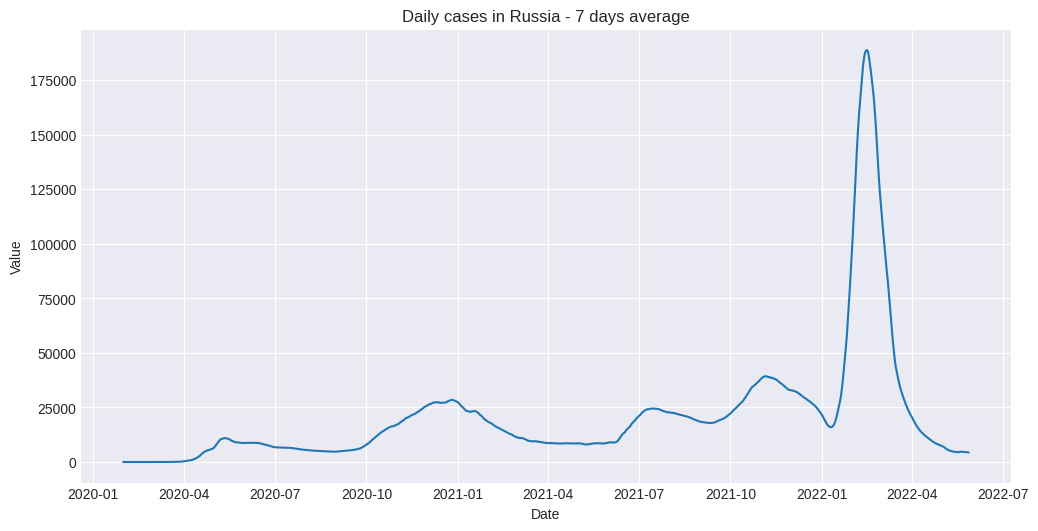

In [15]:
plot_df(df_Russia, x = df_Russia.date, y = df_Russia.ma_cases, title = 'Daily cases in Russia - 7 days average')   

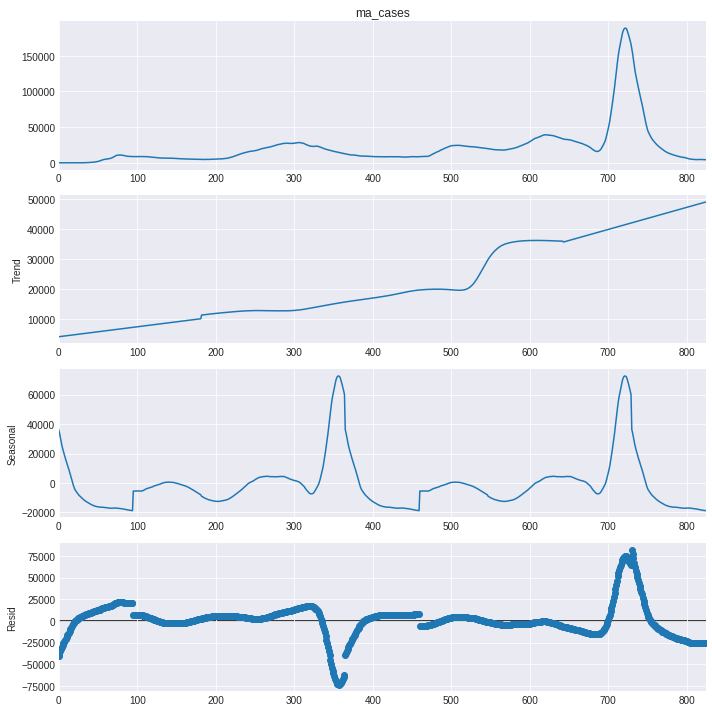

In [16]:
# Additive Decomposition
result_add = seasonal_decompose(df_Russia['ma_cases'], model = 'additive', extrapolate_trend = 'freq', period = 365)

# Plot
plt.rcParams.update({'figure.figsize': (10, 10)})
result_add.plot().suptitle('')
plt.show()

In [17]:
# ADF Test
result = adfuller(df_Russia['ma_cases'].values, autolag = 'AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.8001629345491295
p-value: 0.05825049779715777
Critial Values:
   1%, -3.438489266223099
Critial Values:
   5%, -2.8651325741144573
Critial Values:
   10%, -2.5686830088234025


In [18]:
plt.rcParams.update({'figure.figsize' : (14, 8), 'figure.dpi' : 120})

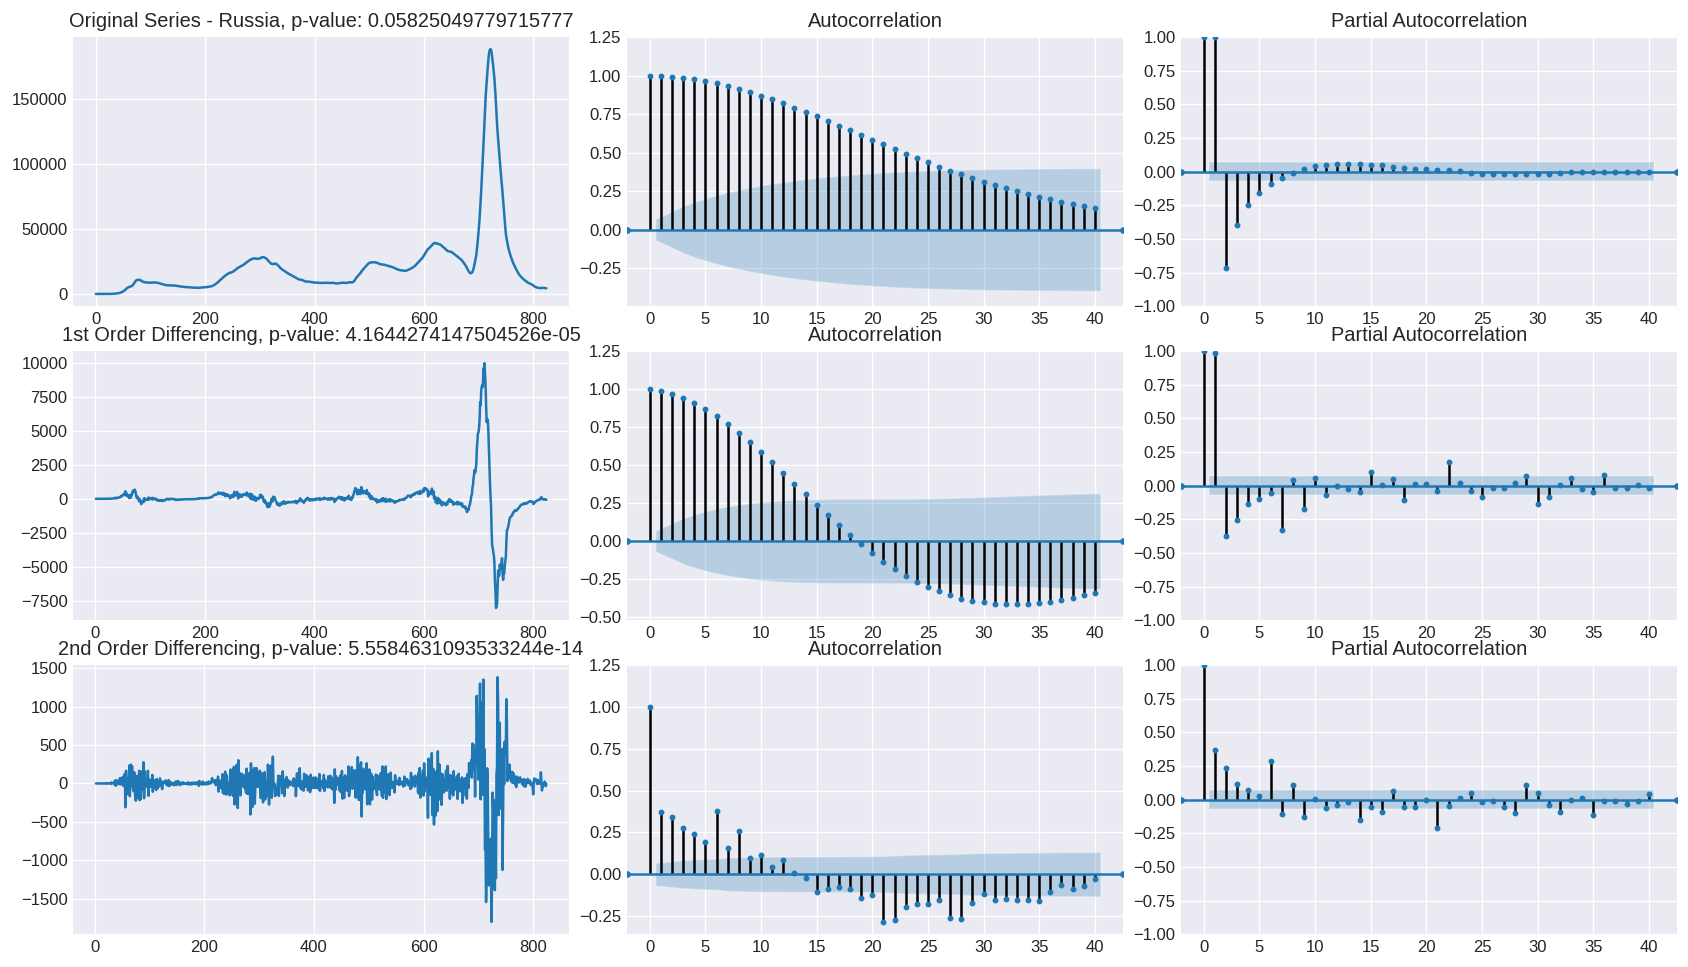

In [19]:
# Original series:
fig, axes = plt.subplots(3, 3)
fig.tight_layout()

axes[0, 0].plot(df_Russia['ma_cases']); axes[0, 0].set_title('Original Series - Russia, p-value: {}'.format(result[1]))
plot_acf(df_Russia['ma_cases'], ax = axes[0, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Russia['ma_cases'], ax = axes[0, 2], lags = 40, marker = '.', method = 'ywm')

# 1st differencing
result1 = adfuller(df_Russia['ma_cases'].diff().dropna().values, autolag = 'AIC')
axes[1, 0].plot(df_Russia['ma_cases'].diff()); axes[1, 0].set_title('1st Order Differencing, p-value: {}'.format(result1[1]))
plot_acf(df_Russia['ma_cases'].diff().dropna(), ax = axes[1, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Russia['ma_cases'].diff().dropna(), ax = axes[1, 2], lags = 40, marker = '.', method = 'ywm')

# 2nd differencing
result2 = adfuller(df_Russia['ma_cases'].diff().diff().dropna().values, autolag = 'AIC')
axes[2, 0].plot(df_Russia['ma_cases'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing, p-value: {}'.format(result2[1]))
plot_acf(df_Russia['ma_cases'].diff().diff().dropna(), ax = axes[2, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Russia['ma_cases'].diff().diff().dropna(), ax = axes[2, 2], lags = 40, marker = '.', method = 'ywm')

plt.show()

In [20]:
# 6, 2, 6 ARIMA Model - based on the ACF and PACF plots
model = ARIMA(df_Russia['ma_cases'], order = (6, 2, 6))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:               ma_cases   No. Observations:                  825
Model:                 ARIMA(6, 2, 6)   Log Likelihood               -5503.443
Date:                Sun, 29 May 2022   AIC                          11032.887
Time:                        18:25:36   BIC                          11094.155
Sample:                             0   HQIC                         11056.392
                                - 825                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0658      0.036     -1.808      0.071      -0.137       0.006
ar.L2          0.7435      0.028     26.696      0.000       0.689       0.798
ar.L3          0.8689      0.044     19.546      0.0

In [21]:
plt.rcParams.update({'figure.figsize' : (12, 6), 'figure.dpi' : 120})

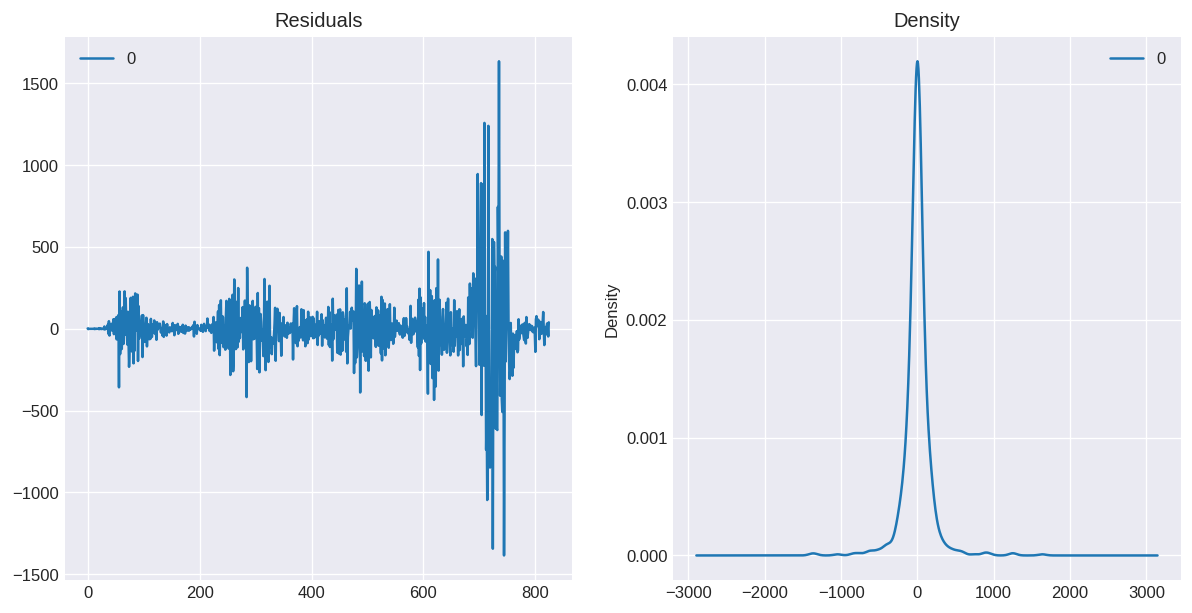

In [22]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)

fig, ax = plt.subplots(1, 2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(kind = 'kde', title = 'Density', ax = ax[1])

plt.show()

In [23]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df_Russia['ma_cases'][ : int(.9 * len(df_Russia))]
test = df_Russia['ma_cases'][int(.9 * len(df_Russia)) :]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


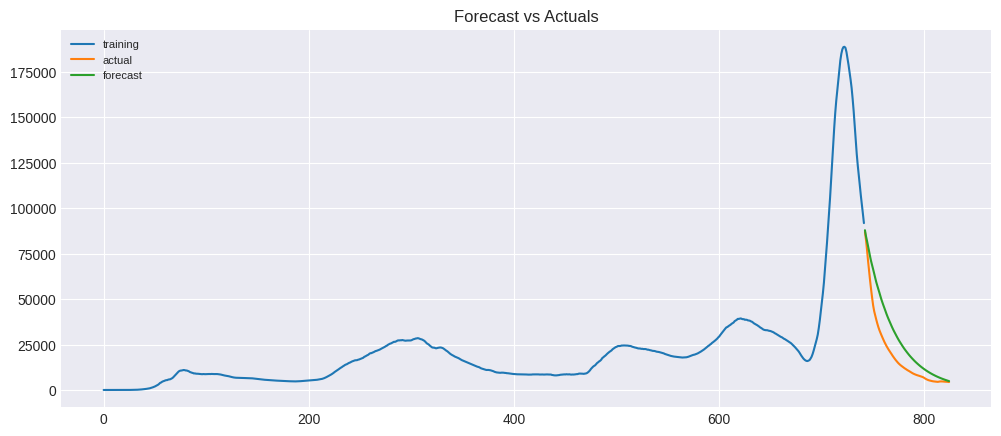

In [24]:
# Build Model
model = ARIMA(np.log(train), order = (6, 2, 6))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(len(test), alpha = 0.05)  # 95% conf
fc = np.exp(fc)

# Make as pandas series
fc_series = pd.Series(fc, index = test.index)

# Plot
plt.figure(figsize = (12, 5), dpi = 100)
plt.plot(train, label = 'training')
plt.plot(test, label = 'actual')
plt.plot(fc_series, label = 'forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc = 'upper left', fontsize = 8)

plt.show()

In [ ]:
print('MSE: ', mean_squared_error(test, fc_series))
print('RMSE: ', np.sqrt(mean_squared_error(test, fc_series)))
print('MAE: ', mean_absolute_error(test, fc_series))
print('MAPE: ', mean_absolute_percentage_error(test, fc_series))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


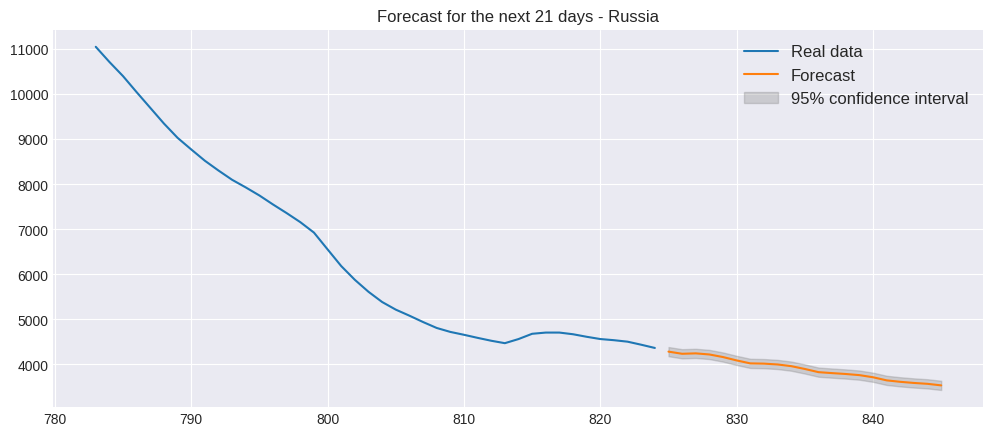

In [26]:
# Build Model
model = ARIMA(np.log(df_Russia['ma_cases']), order = (6, 2, 6))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(21, alpha = 0.05)  # 95% conf
fc = np.exp(fc)

# Make as pandas series
fc_series = pd.Series(fc)

# Plot
plt.figure(figsize = (12, 5), dpi = 100)
plt.plot(df_Russia['ma_cases'][int(0.95 * len(df_Russia)):], label = 'Real data')
plt.plot(fc_series, label = 'Forecast')
ci = 1.96 * np.std(fc_series) / np.sqrt(len(fc_series))
plt.fill_between(fc_series.index, np.array(fc_series - ci), np.array(fc_series + ci), color = 'grey', alpha = .3, label = '95% confidence interval')

plt.title('Forecast for the next 21 days - Russia')
plt.legend(loc = 'upper right', fontsize = 12)
plt.show()

### Creating model on Serbian data:

In [36]:
df_Serbia = df_Serbia[df_Serbia['ma_cases'] != 0]
df_Serbia.index = np.arange(0, len(df_Serbia))

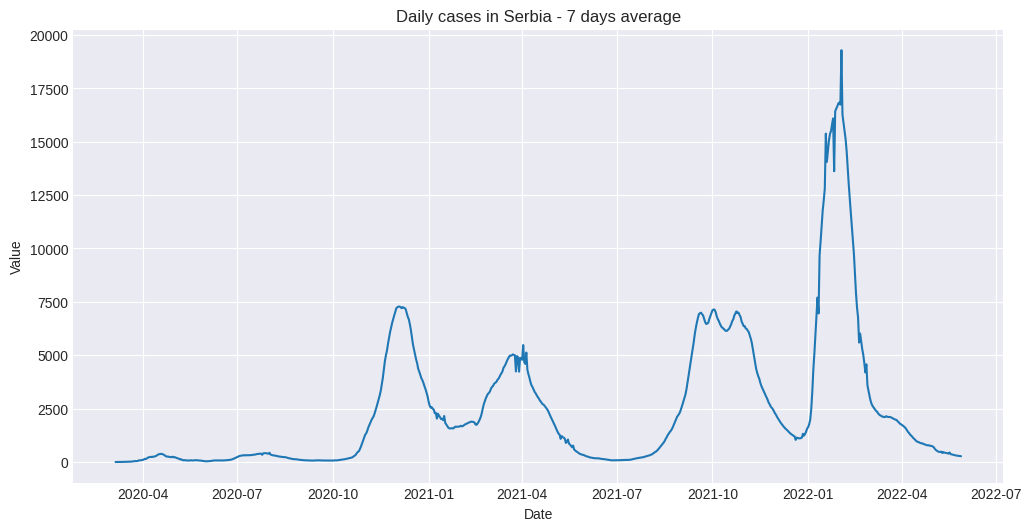

In [37]:
plot_df(df_Serbia, x = df_Serbia.date, y = df_Serbia.ma_cases, title = 'Daily cases in Serbia - 7 days average')

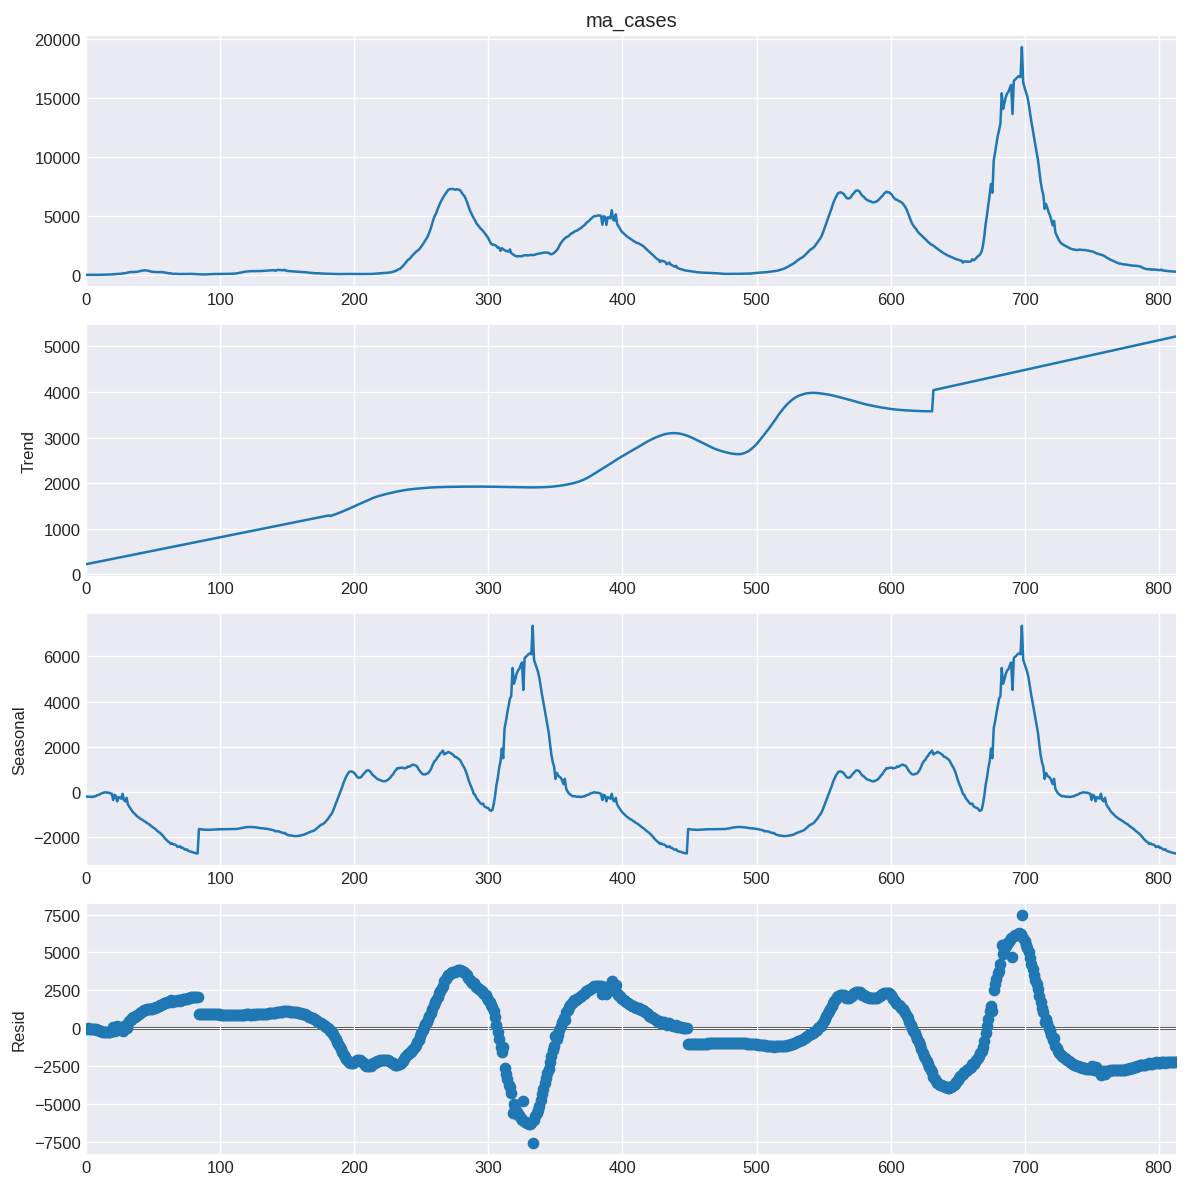

In [38]:
# Additive Decomposition
result_add = seasonal_decompose(df_Serbia['ma_cases'], model = 'additive', extrapolate_trend = 'freq', period = 365)

# Plot
plt.rcParams.update({'figure.figsize': (10, 10)})
result_add.plot().suptitle('')
plt.show()

In [39]:
# ADF Test
result = adfuller(df_Serbia['ma_cases'].values, autolag = 'AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.2804729864925966
p-value: 0.015774217899081344
Critial Values:
   1%, -3.438633612472885
Critial Values:
   5%, -2.865196199232788
Critial Values:
   10%, -2.5687169024206713


In [40]:
plt.rcParams.update({'figure.figsize': (14, 8), 'figure.dpi': 120})

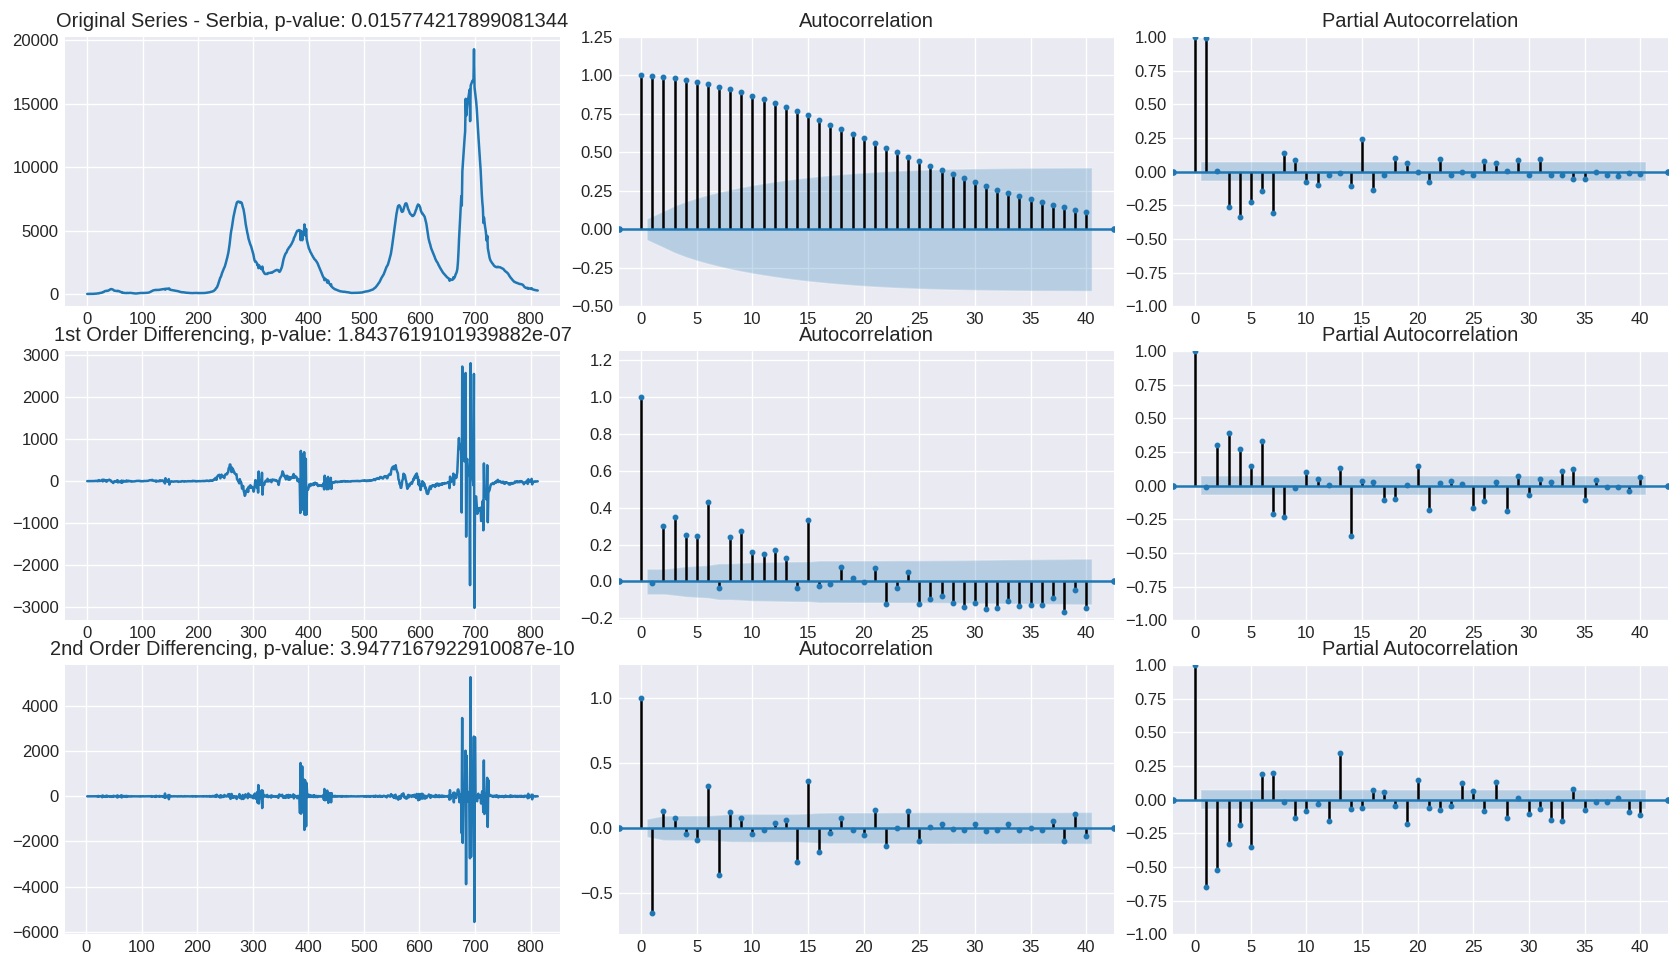

In [41]:
# Original series:
fig, axes = plt.subplots(3, 3)
fig.tight_layout()

axes[0, 0].plot(df_Serbia['ma_cases']); axes[0, 0].set_title('Original Series - Serbia, p-value: {}'.format(result[1]))
plot_acf(df_Serbia['ma_cases'], ax = axes[0, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Serbia['ma_cases'], ax = axes[0, 2], lags = 40, marker = '.', method = 'ywm')

# 1st differencing
result1 = adfuller(df_Serbia['ma_cases'].diff().dropna().values, autolag = 'AIC')
axes[1, 0].plot(df_Serbia['ma_cases'].diff()); axes[1, 0].set_title('1st Order Differencing, p-value: {}'.format(result1[1]))
plot_acf(df_Serbia['ma_cases'].diff().dropna(), ax = axes[1, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Serbia['ma_cases'].diff().dropna(), ax = axes[1, 2], lags = 40, marker = '.', method = 'ywm')

# 2nd differencing
result2 = adfuller(df_Serbia['ma_cases'].diff().diff().dropna().values, autolag = 'AIC')
axes[2, 0].plot(df_Serbia['ma_cases'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing, p-value: {}'.format(result2[1]))
plot_acf(df_Serbia['ma_cases'].diff().diff().dropna(), ax = axes[2, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Serbia['ma_cases'].diff().diff().dropna(), ax = axes[2, 2], lags = 40, marker = '.', method = 'ywm')

plt.show()

In [32]:
# 3, 1, 6 ARIMA Model
model = ARIMA(df_Serbia['ma_cases'], order = (3, 1, 6))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:               ma_cases   No. Observations:                  823
Model:                 ARIMA(3, 1, 6)   Log Likelihood               -5604.724
Date:                Sun, 29 May 2022   AIC                          11229.447
Time:                        18:28:06   BIC                          11276.565
Sample:                             0   HQIC                         11247.524
                                - 823                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0843      0.025    -42.559      0.000      -1.134      -1.034
ar.L2         -0.7147      0.043    -16.515      0.000      -0.800      -0.630
ar.L3         -0.2511      0.043     -5.824      0.0

In [42]:
plt.rcParams.update({'figure.figsize':(12, 6), 'figure.dpi': 120})

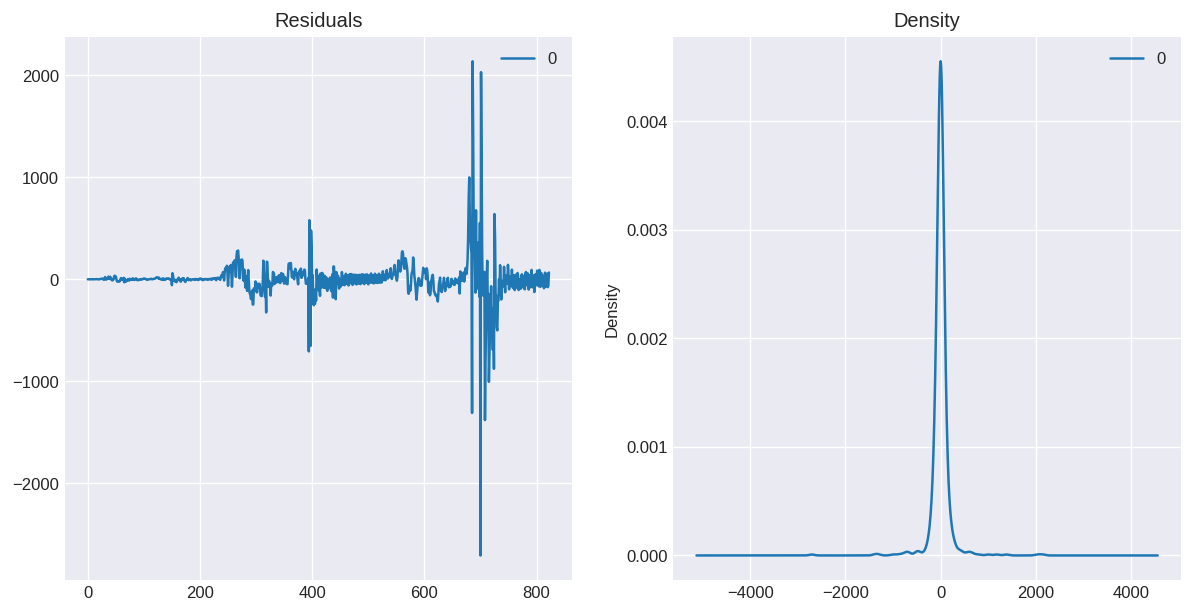

In [43]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)

fig, ax = plt.subplots(1, 2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(kind = 'kde', title = 'Density', ax = ax[1])

plt.show()

In [44]:
# Create Training and Test
train = df_Serbia['ma_cases'][ : int(.9 * len(df_Serbia))]
test = df_Serbia['ma_cases'][int(.9 * len(df_Serbia)) :]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


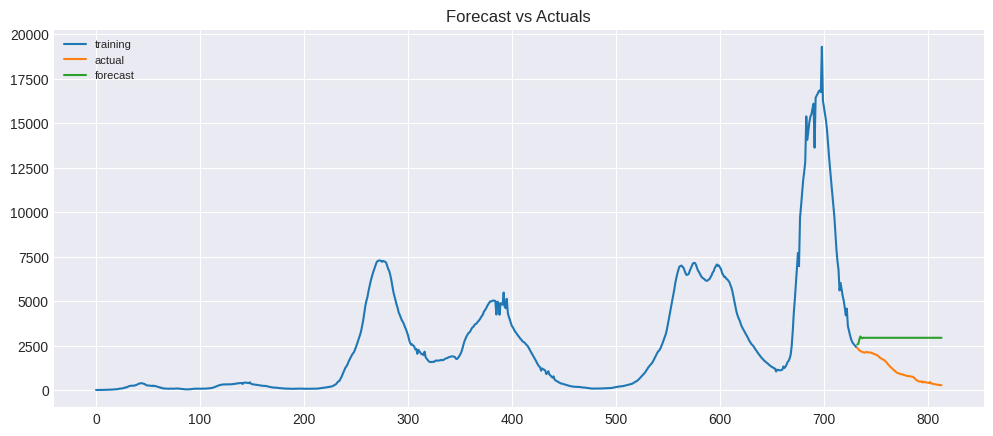

In [45]:
# Build Model
model = ARIMA(train, order = (3, 1, 6))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(len(test), alpha = 0.05)  # 95% conf
# fc = np.exp(fc)

# Make as pandas series
fc_series = pd.Series(fc, index = test.index)

# Plot
plt.figure(figsize = (12,5), dpi = 100)
plt.plot(train, label = 'training')
plt.plot(test, label = 'actual')
plt.plot(fc_series, label = 'forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize = 8)
plt.show()

In [ ]:
print('MSE: ', mean_squared_error(test, fc_series))
print('RMSE: ', np.sqrt(mean_squared_error(test, fc_series)))
print('MAE: ', mean_absolute_error(test, fc_series))
print('MAPE: ', mean_absolute_percentage_error(test, fc_series))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


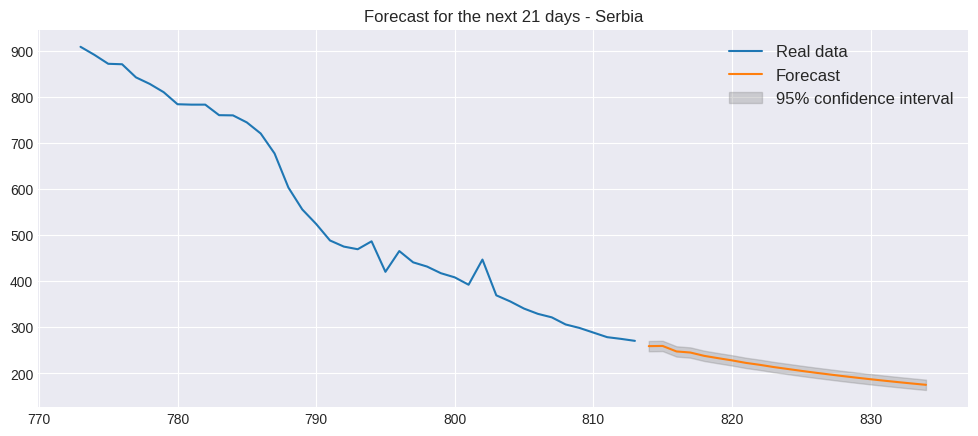

In [47]:
# Build Model
model = ARIMA(np.log(df_Serbia['ma_cases']), order = (3, 1, 6))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(21, alpha = 0.05)  # 95% conf
fc = np.exp(fc)
# Make as pandas series
fc_series = pd.Series(fc)

# Plot
plt.figure(figsize = (12, 5), dpi = 100)
plt.plot(df_Serbia['ma_cases'][int(0.95 * len(df_Serbia)):], label = 'Real data')
plt.plot(fc_series, label = 'Forecast')
ci = 1.96 * np.std(fc_series) / np.sqrt(len(fc_series))
plt.fill_between(fc_series.index, np.array(fc_series - ci), np.array(fc_series + ci), color = 'grey', alpha = .3, label = '95% confidence interval')

plt.title('Forecast for the next 21 days - Serbia')
plt.legend(loc = 'upper right', fontsize = 12)
plt.show()

### Creating model on Sweden data:

In [48]:
df_Sweden = df_Sweden[df_Sweden['ma_cases'] != 0]
df_Sweden.index = np.arange(0, len(df_Sweden))

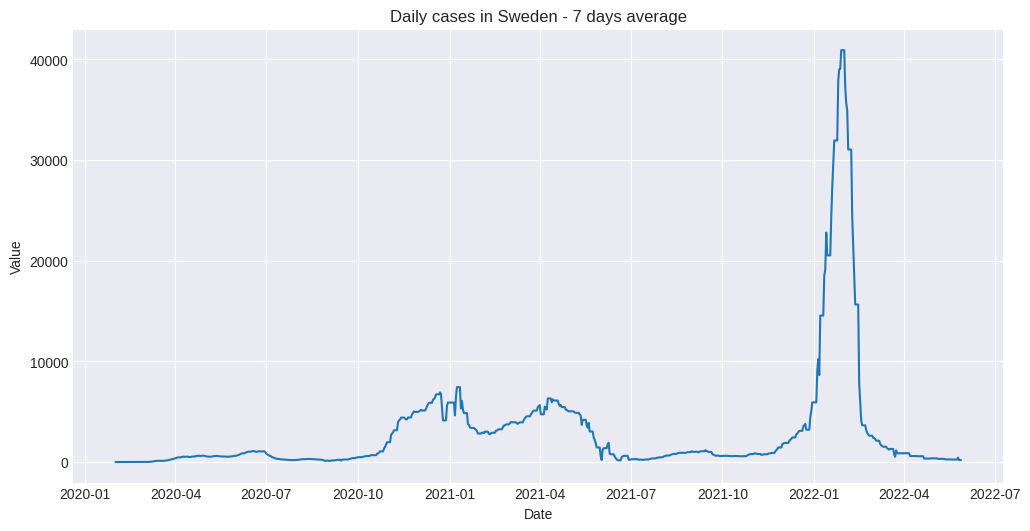

In [49]:
plot_df(df_Sweden, x = df_Sweden.date, y = df_Sweden.ma_cases, title = 'Daily cases in Sweden - 7 days average')

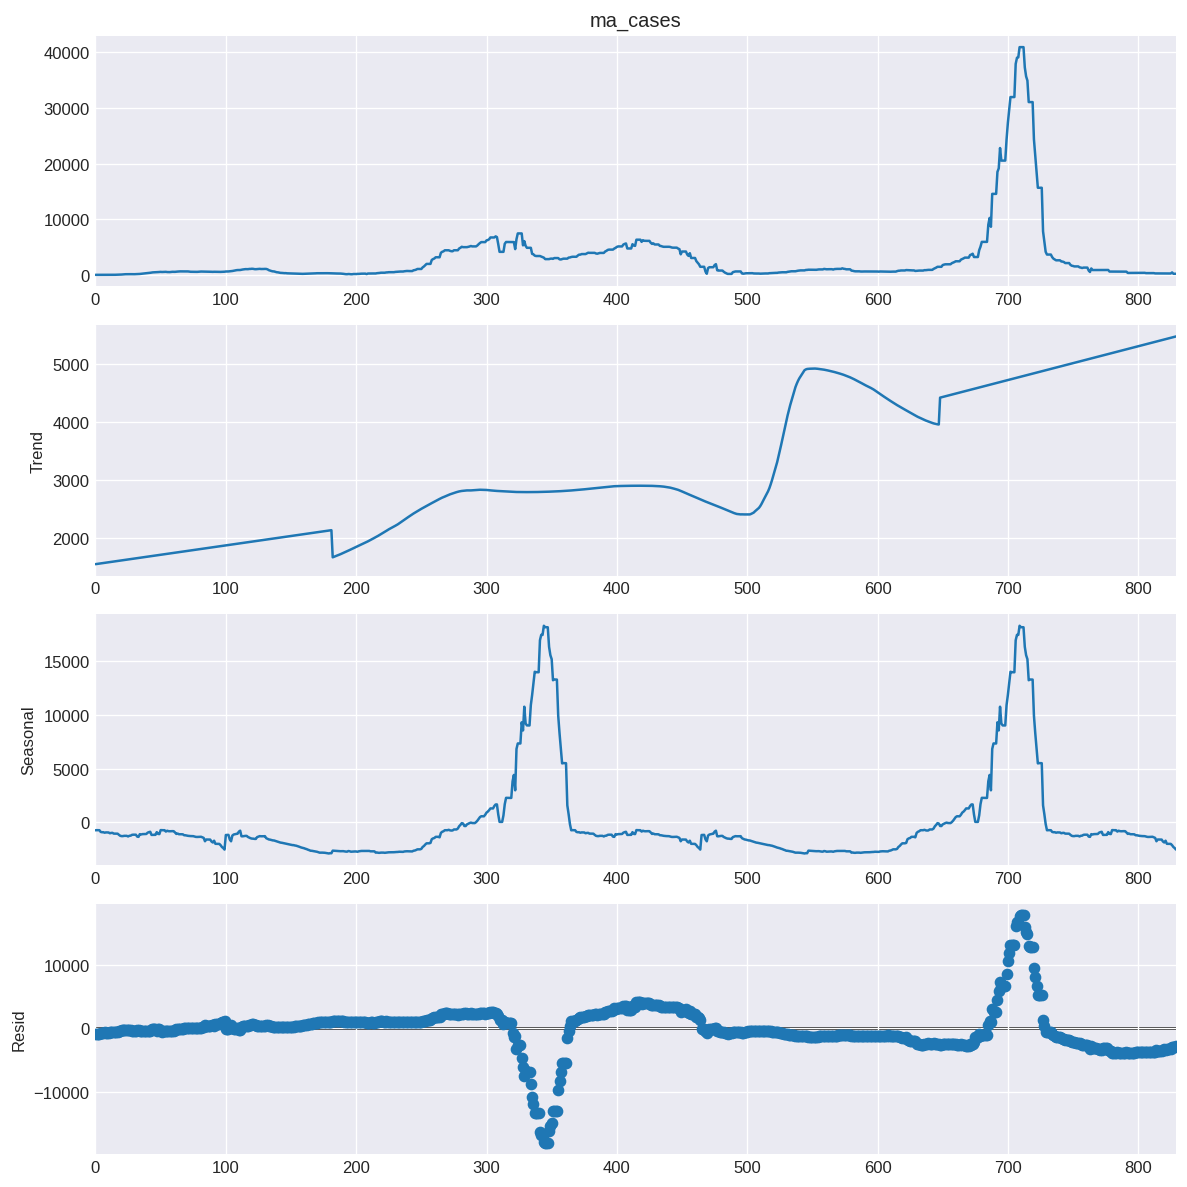

In [50]:
# Additive Decomposition
result_add = seasonal_decompose(df_Sweden['ma_cases'], model = 'additive', extrapolate_trend = 'freq', period = 365)

# Plot
plt.rcParams.update({'figure.figsize': (10, 10)})
result_add.plot().suptitle('')
plt.show()

In [51]:
# ADF Test
result = adfuller(df_Sweden['ma_cases'].values, autolag = 'AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.3494169588438543
p-value: 0.01280895709407566
Critial Values:
   1%, -3.4384690549764856
Critial Values:
   5%, -2.8651236651346306
Critial Values:
   10%, -2.568678262976669


In [52]:
plt.rcParams.update({'figure.figsize' : (14, 8), 'figure.dpi' : 120})

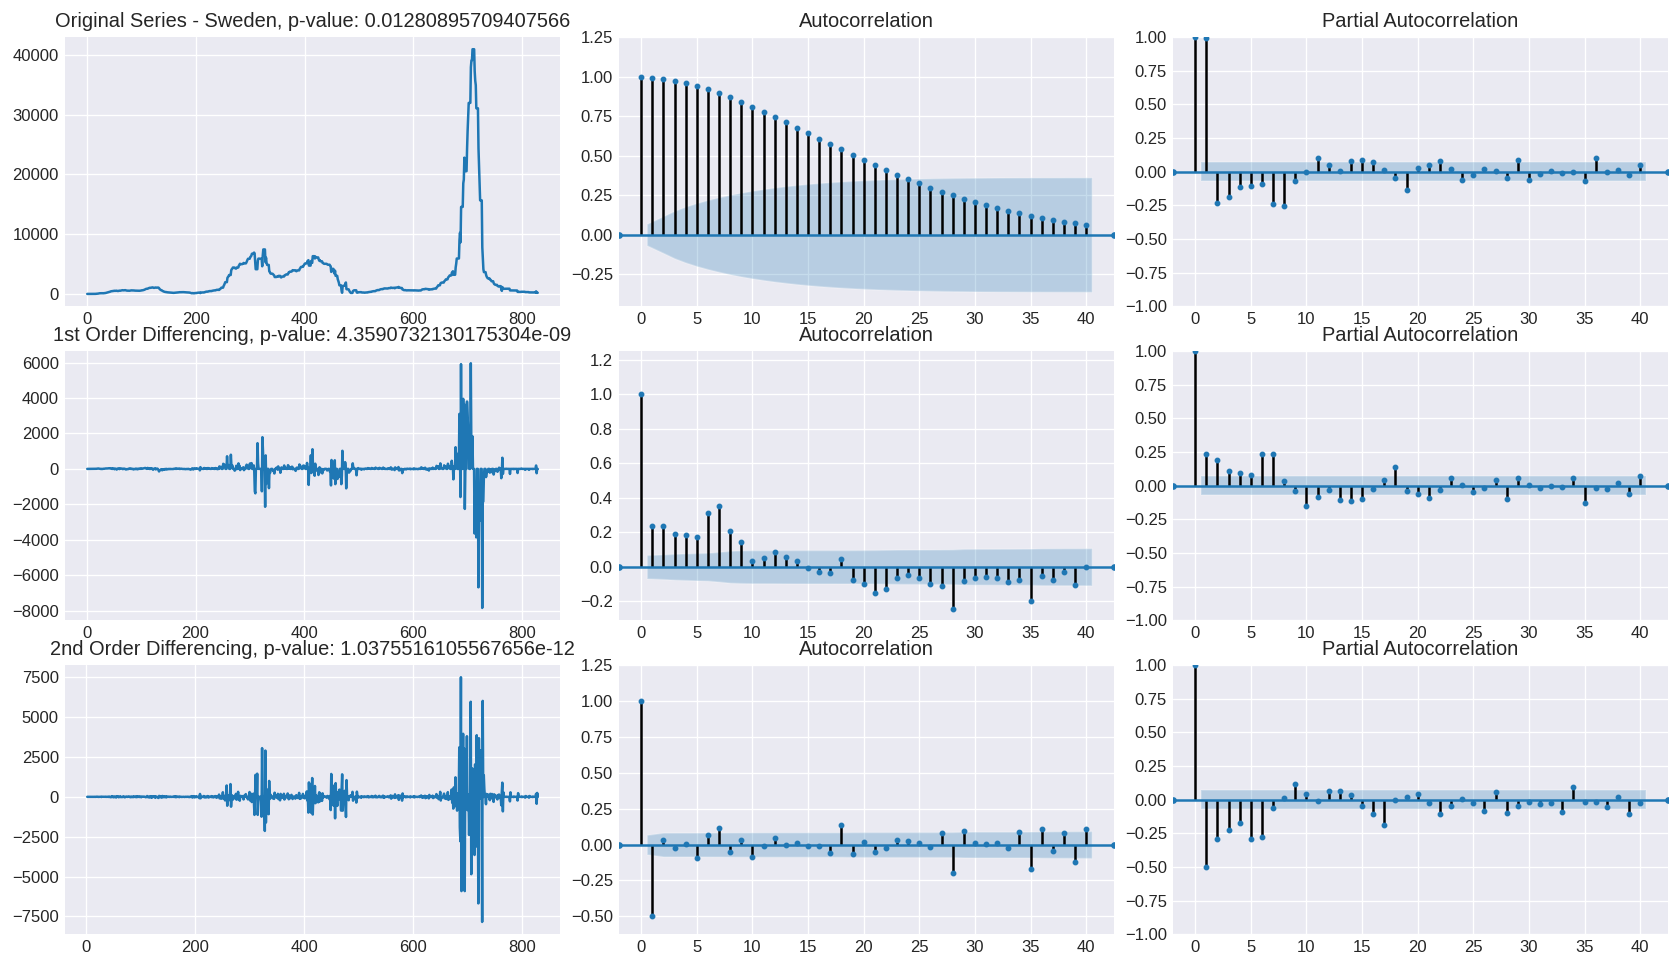

In [53]:
# Original series:
fig, axes = plt.subplots(3, 3)
fig.tight_layout()

axes[0, 0].plot(df_Sweden['ma_cases']); axes[0, 0].set_title('Original Series - Sweden, p-value: {}'.format(result[1]))
plot_acf(df_Sweden['ma_cases'], ax = axes[0, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Sweden['ma_cases'], ax = axes[0, 2], lags = 40, marker = '.', method = 'ywm')

# 1st differencing
result1 = adfuller(df_Sweden['ma_cases'].diff().dropna().values, autolag = 'AIC')
axes[1, 0].plot(df_Sweden['ma_cases'].diff()); axes[1, 0].set_title('1st Order Differencing, p-value: {}'.format(result1[1]))
plot_acf(df_Sweden['ma_cases'].diff().dropna(), ax = axes[1, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Sweden['ma_cases'].diff().dropna(), ax = axes[1, 2], lags = 40, marker = '.', method = 'ywm')

# 2nd differencing
result2 = adfuller(df_Sweden['ma_cases'].diff().diff().dropna().values, autolag = 'AIC')
axes[2, 0].plot(df_Sweden['ma_cases'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing, p-value: {}'.format(result2[1]))
plot_acf(df_Sweden['ma_cases'].diff().diff().dropna(), ax = axes[2, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Sweden['ma_cases'].diff().diff().dropna(), ax = axes[2, 2], lags = 40, marker = '.', method = 'ywm')

plt.show()

In [54]:
# 1, 1, 6 ARIMA Model
model = ARIMA(df_Sweden['ma_cases'], order = (1, 1, 6))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               ma_cases   No. Observations:                  830
Model:                 ARIMA(1, 1, 6)   Log Likelihood               -6459.318
Date:                Sun, 29 May 2022   AIC                          12934.635
Time:                        18:32:09   BIC                          12972.397
Sample:                             0   HQIC                         12949.117
                                - 830                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7279      0.022     33.519      0.000       0.685       0.771
ma.L1         -0.7020      0.024    -29.440      0.000      -0.749      -0.655
ma.L2          0.0964      0.021      4.506      0.0

In [55]:
plt.rcParams.update({'figure.figsize' : (12, 6), 'figure.dpi' : 120})

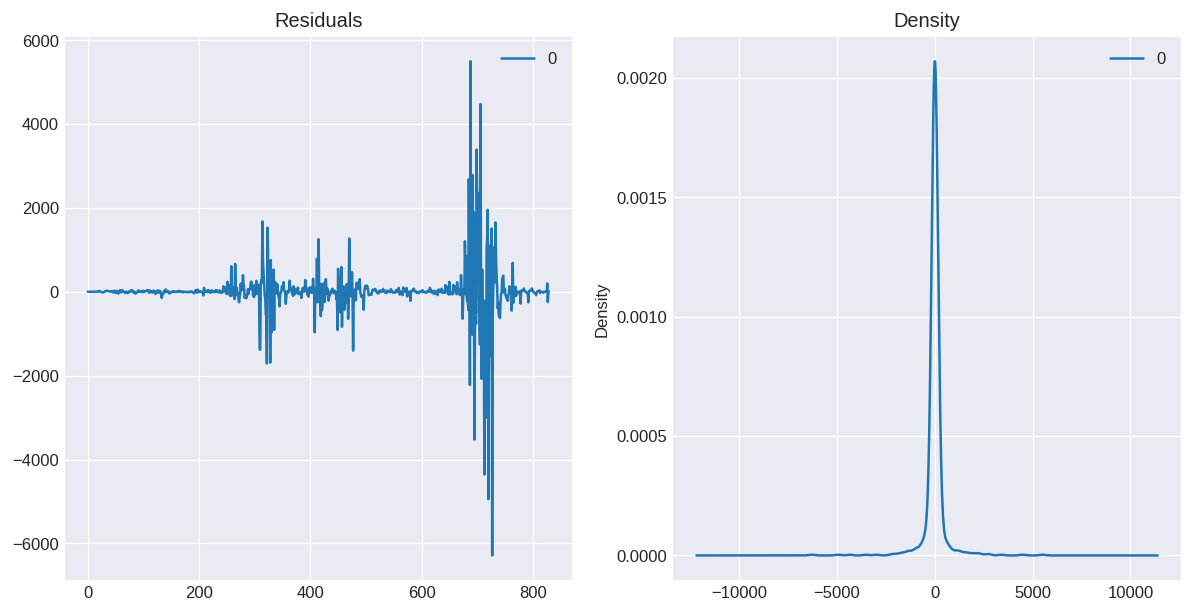

In [56]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)

fig, ax = plt.subplots(1, 2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(kind = 'kde', title = 'Density', ax = ax[1])

plt.show()

In [57]:
# Create Training and Test
train = df_Sweden['ma_cases'][ : int(.9 * len(df_Sweden))]
test = df_Sweden['ma_cases'][int(.9 * len(df_Sweden)) :]

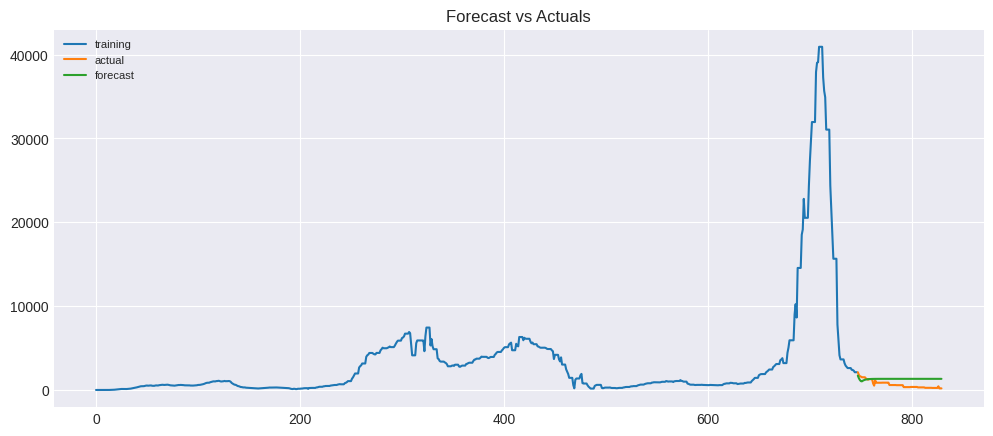

In [58]:
# Build Model 
model = ARIMA(train, order = (1, 1, 6))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(len(test), alpha = 0.05)  # 95% conf
# fc = np.exp(fc)

# Make as pandas series
fc_series = pd.Series(fc, index = test.index)

# Plot
plt.figure(figsize = (12,5), dpi = 100)
plt.plot(train, label = 'training')
plt.plot(test, label = 'actual')
plt.plot(fc_series, label = 'forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize = 8)
plt.show()

In [ ]:
print('MSE: ', mean_squared_error(test, fc_series))
print('RMSE: ', np.sqrt(mean_squared_error(test, fc_series)))
print('MAE: ', mean_absolute_error(test, fc_series))
print('MAPE: ', mean_absolute_percentage_error(test, fc_series))

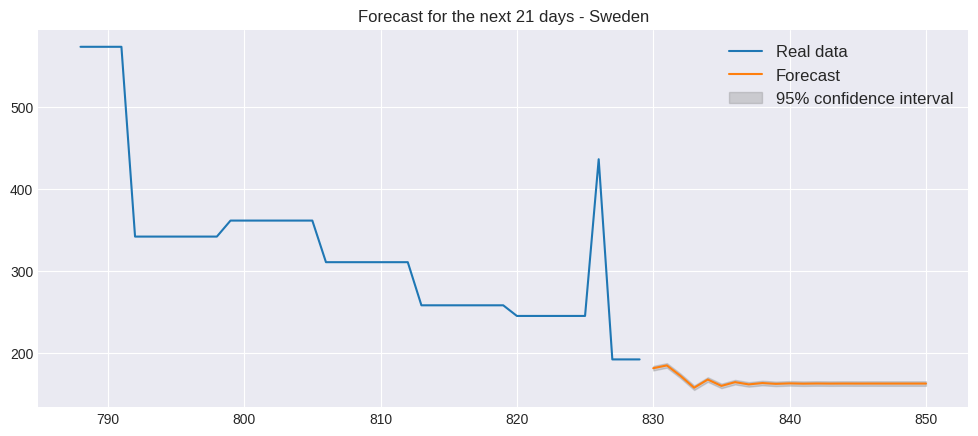

In [76]:
# Build Model 
model = ARIMA(np.log(df_Sweden['ma_cases']), order = (1, 1, 6))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(21, alpha = 0.05)  # 95% conf
fc = np.exp(fc)
# Make as pandas series
fc_series = pd.Series(fc)

# Plot
plt.figure(figsize = (12, 5), dpi = 100)
plt.plot(df_Sweden['ma_cases'][int(0.95 * len(df_Sweden)):], label = 'Real data')
plt.plot(fc_series, label = 'Forecast')
ci = 1.96 * np.std(fc_series) / np.sqrt(len(fc_series))
plt.fill_between(fc_series.index, np.array(fc_series - ci), np.array(fc_series + ci), color = 'grey', alpha = .3, label = '95% confidence interval')

plt.title('Forecast for the next 21 days - Sweden')
plt.legend(loc = 'upper right', fontsize = 12)
plt.show()

### Creating model on Italy data:

In [62]:
df_Italy = df_Italy[df_Italy['ma_cases'] != 0]
df_Italy.index = np.arange(0, len(df_Italy))

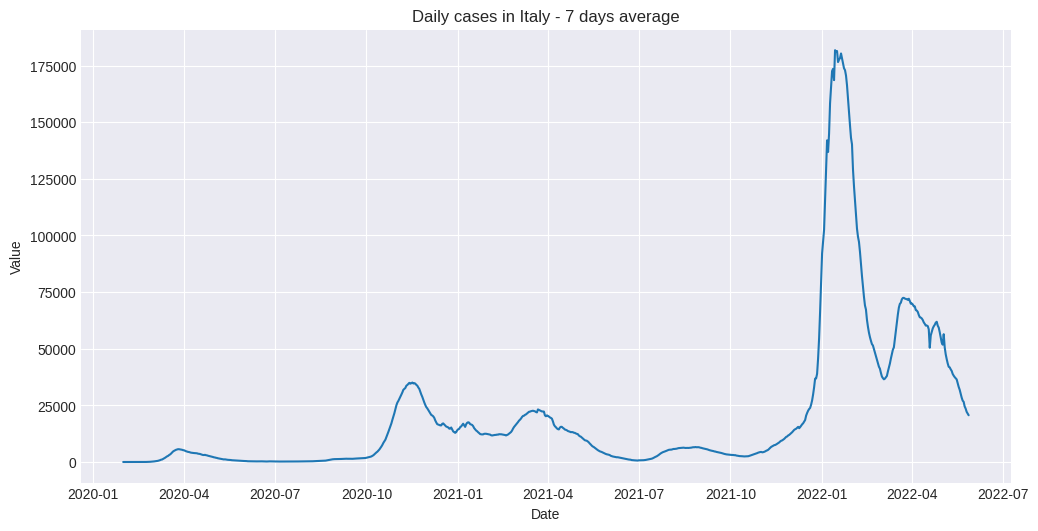

In [63]:
plot_df(df_Italy, x = df_Italy.date, y = df_Italy.ma_cases, title = 'Daily cases in Italy - 7 days average')

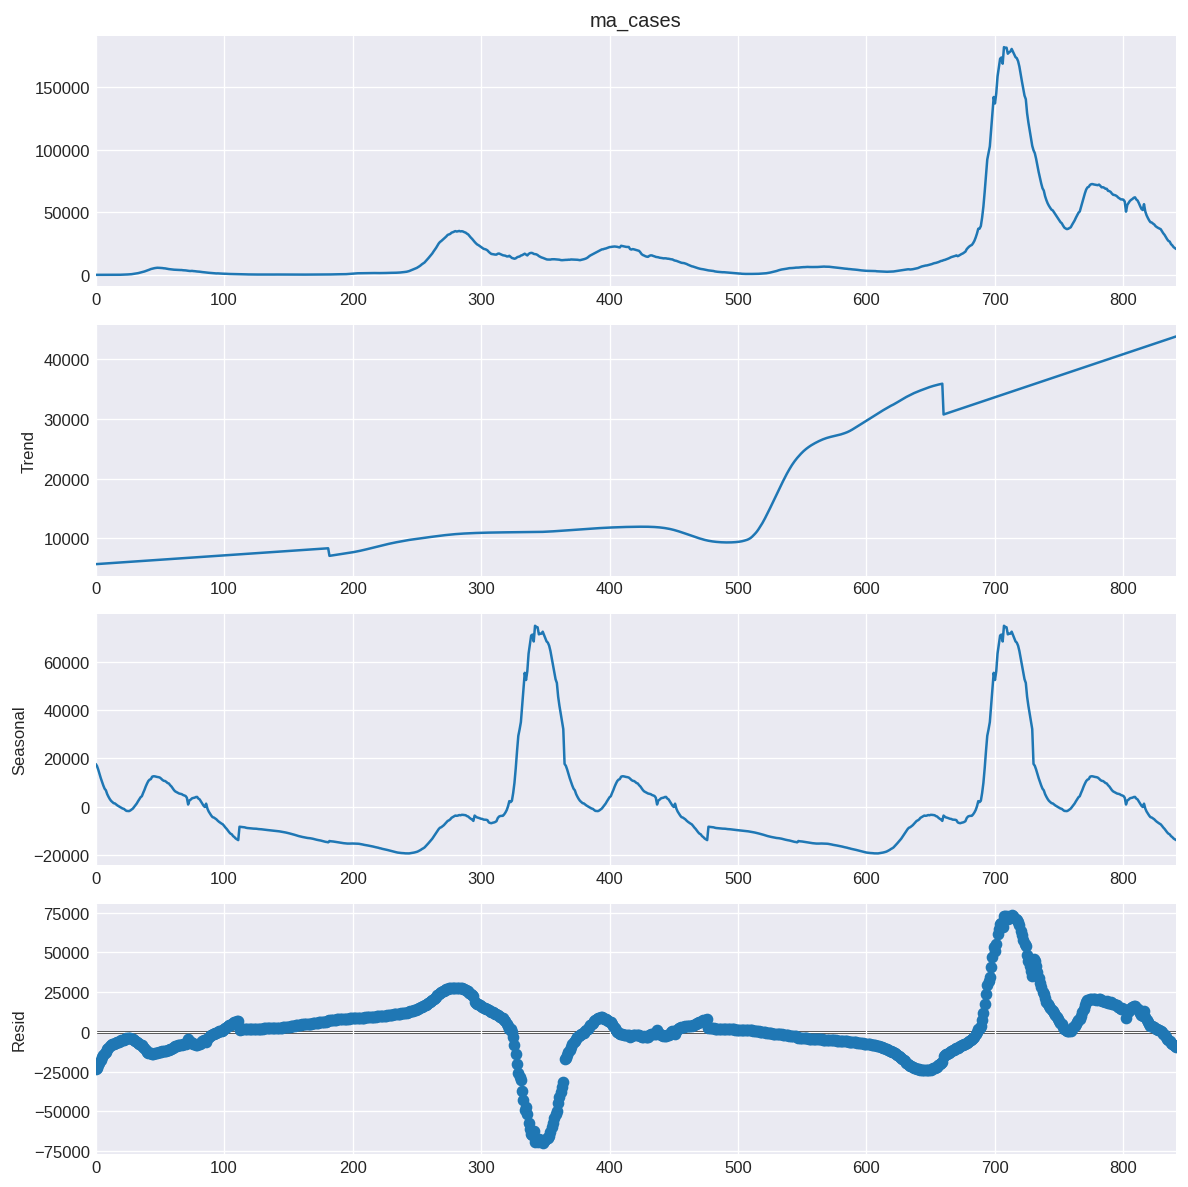

In [64]:
# Additive Decomposition
result_add = seasonal_decompose(df_Italy['ma_cases'], model = 'additive', extrapolate_trend = 'freq', period = 365)

# Plot
plt.rcParams.update({'figure.figsize': (10, 10)})
result_add.plot().suptitle('')
plt.show()

In [65]:
# ADF Test
result = adfuller(df_Italy['ma_cases'].values, autolag = 'AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.585162822052648
p-value: 0.09610274875641833
Critial Values:
   1%, -3.4383498644698274
Critial Values:
   5%, -2.865071125564052
Critial Values:
   10%, -2.568650275133849


In [66]:
plt.rcParams.update({'figure.figsize' : (14, 8), 'figure.dpi' : 120})

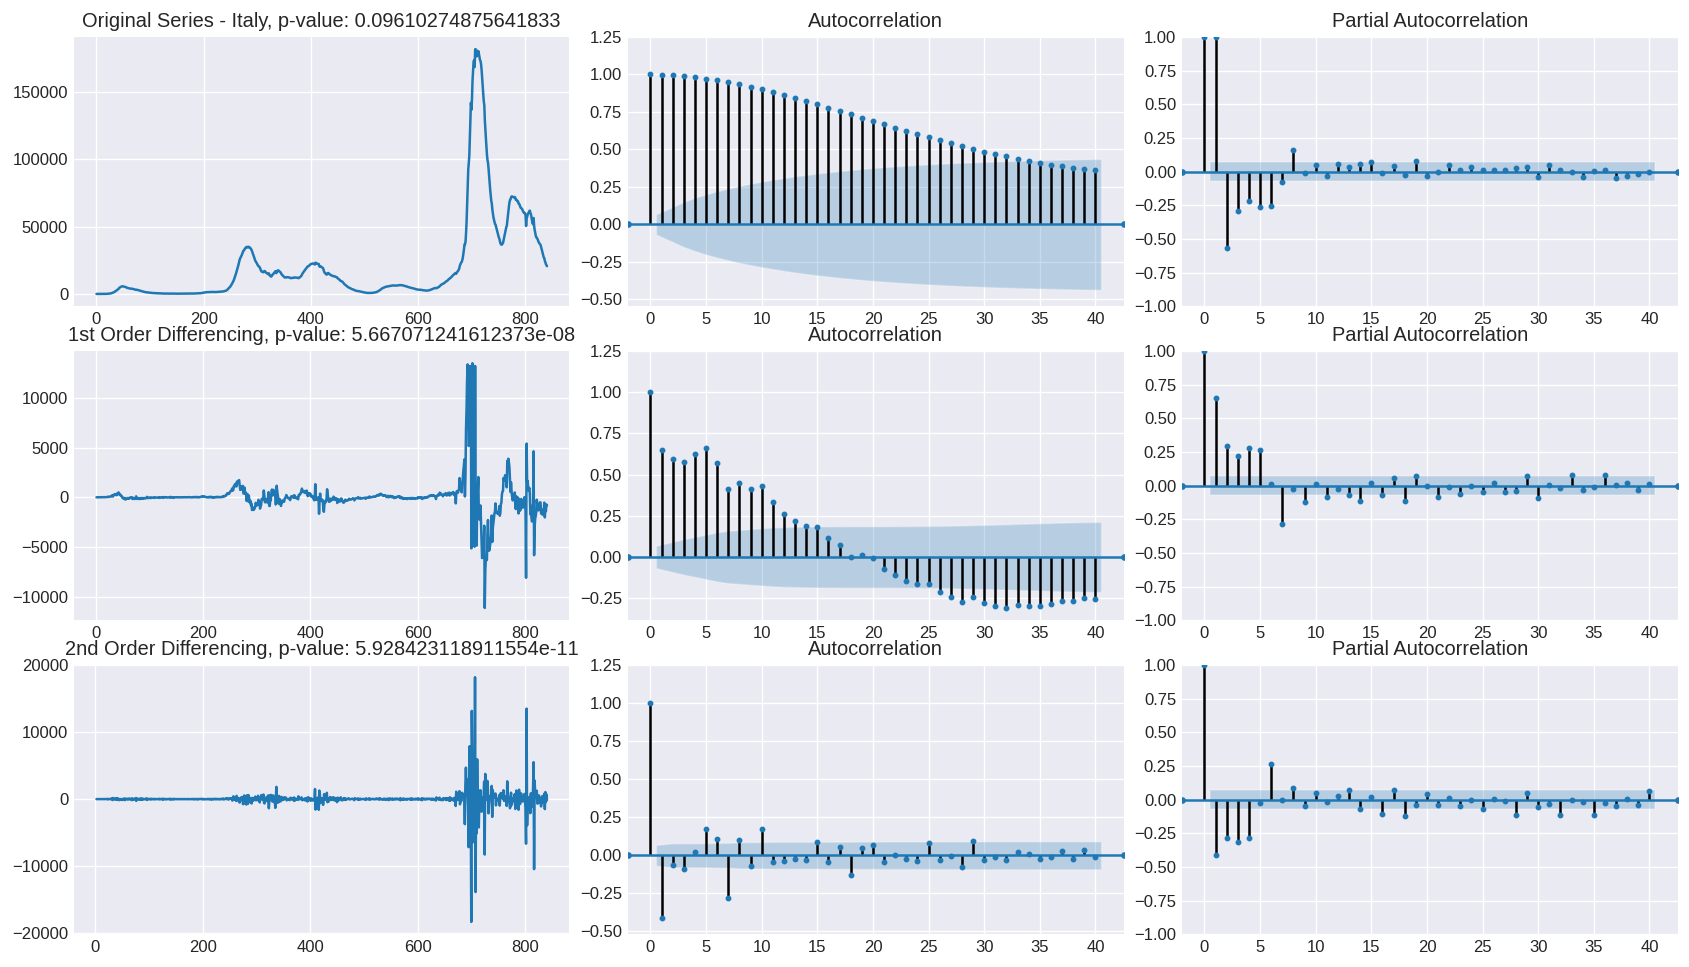

In [67]:
# Original series:
fig, axes = plt.subplots(3, 3)
fig.tight_layout()

axes[0, 0].plot(df_Italy['ma_cases']); axes[0, 0].set_title('Original Series - Italy, p-value: {}'.format(result[1]))
plot_acf(df_Italy['ma_cases'], ax = axes[0, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Italy['ma_cases'], ax = axes[0, 2], lags = 40, marker = '.', method = 'ywm')

# 1st differencing
result1 = adfuller(df_Italy['ma_cases'].diff().dropna().values, autolag = 'AIC')
axes[1, 0].plot(df_Italy['ma_cases'].diff()); axes[1, 0].set_title('1st Order Differencing, p-value: {}'.format(result1[1]))
plot_acf(df_Italy['ma_cases'].diff().dropna(), ax = axes[1, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Italy['ma_cases'].diff().dropna(), ax = axes[1, 2], lags = 40, marker = '.', method = 'ywm')

# 2nd differencing
result2 = adfuller(df_Italy['ma_cases'].diff().diff().dropna().values, autolag = 'AIC')
axes[2, 0].plot(df_Italy['ma_cases'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing, p-value: {}'.format(result2[1]))
plot_acf(df_Italy['ma_cases'].diff().diff().dropna(), ax = axes[2, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Italy['ma_cases'].diff().diff().dropna(), ax = axes[2, 2], lags = 40, marker = '.', method = 'ywm')

plt.show()

In [68]:
# 1, 2, 1 ARIMA Model
model = ARIMA(df_Italy['ma_cases'], order = (1, 2, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               ma_cases   No. Observations:                  842
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -7213.786
Date:                Sun, 29 May 2022   AIC                          14433.572
Time:                        18:36:03   BIC                          14447.772
Sample:                             0   HQIC                         14439.014
                                - 842                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0046      0.016      0.297      0.767      -0.026       0.035
ma.L1         -0.6736      0.012    -57.242      0.000      -0.697      -0.651
sigma2      1.688e+06   1.77e+04     95.627      0.0

In [69]:
plt.rcParams.update({'figure.figsize' : (12, 6), 'figure.dpi' : 120})

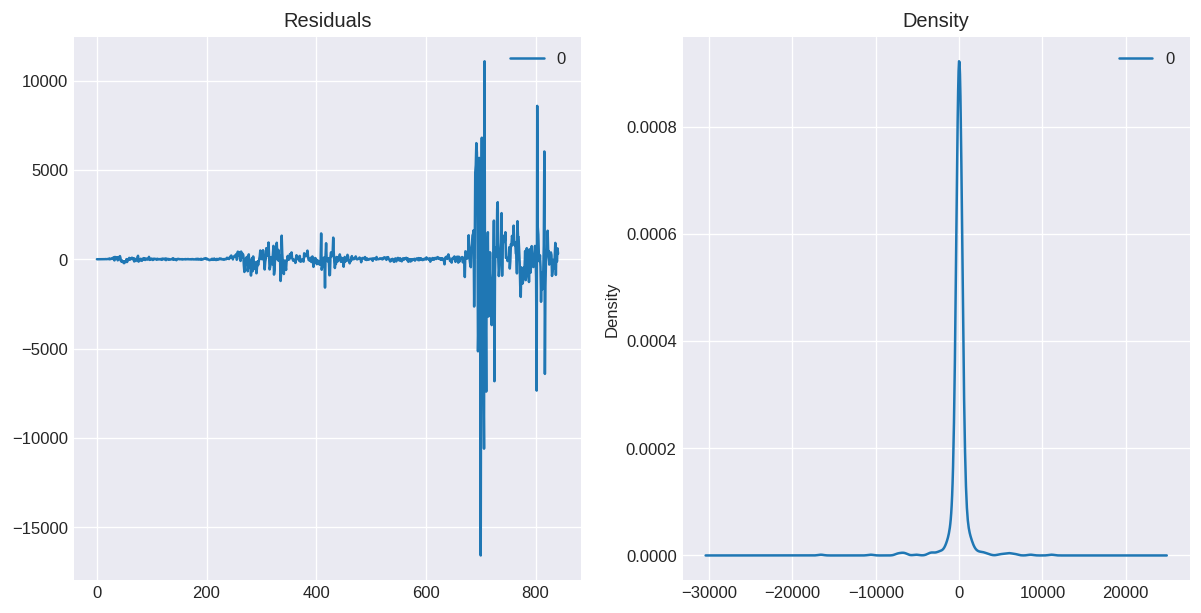

In [70]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)

fig, ax = plt.subplots(1, 2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(kind = 'kde', title = 'Density', ax = ax[1])

plt.show()

In [71]:
# Create Training and Test
train = df_Italy['ma_cases'][ : int(.9 * len(df_Italy))]
test = df_Italy['ma_cases'][int(.9 * len(df_Italy)) :]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


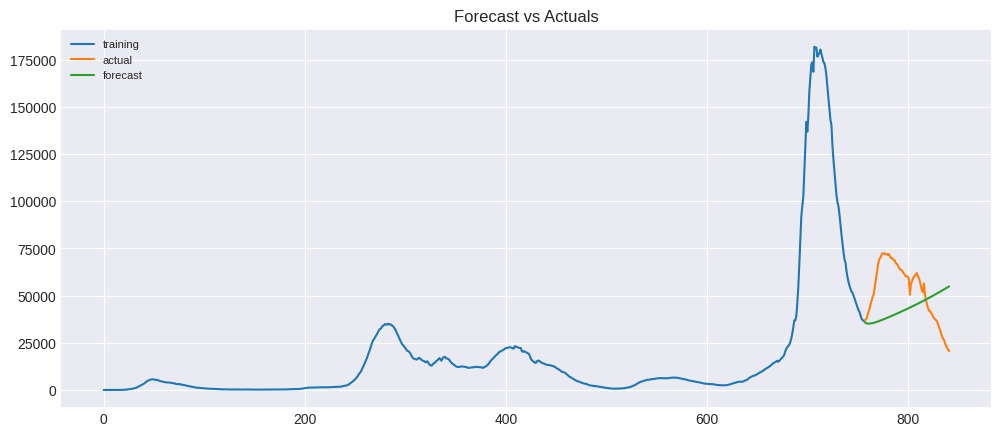

In [72]:
# Build Model 
model = ARIMA(np.log(train), order = (6, 2, 7))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(len(test), alpha = 0.05)  # 95% conf
fc = np.exp(fc)

# Make as pandas series
fc_series = pd.Series(fc, index = test.index)

# Plot
plt.figure(figsize = (12,5), dpi = 100)
plt.plot(train, label = 'training')
plt.plot(test, label = 'actual')
plt.plot(fc_series, label = 'forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize = 8)
plt.show()

In [ ]:
print('MSE: ', mean_squared_error(test, fc_series))
print('RMSE: ', np.sqrt(mean_squared_error(test, fc_series)))
print('MAE: ', mean_absolute_error(test, fc_series))
print('MAPE: ', mean_absolute_percentage_error(test, fc_series))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


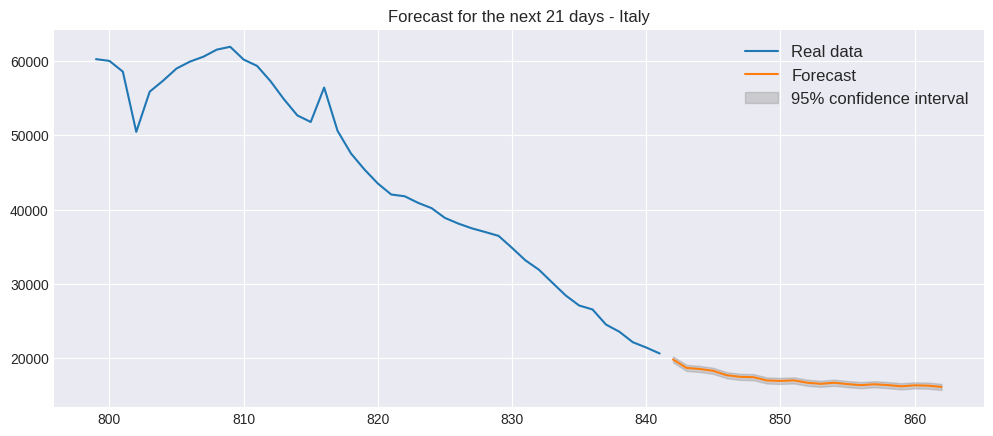

In [74]:
# Build Model
model = ARIMA(np.log(df_Italy['ma_cases']), order = (6, 2, 7))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(21, alpha = 0.05)  # 95% conf
fc = np.exp(fc)
# Make as pandas series
fc_series = pd.Series(fc)

# Plot
plt.figure(figsize = (12, 5), dpi = 100)
plt.plot(df_Italy['ma_cases'][int(0.95 * len(df_Italy)):], label = 'Real data')
plt.plot(fc_series, label = 'Forecast')
ci = 1.96 * np.std(fc_series) / np.sqrt(len(fc_series))
plt.fill_between(fc_series.index, np.array(fc_series - ci), np.array(fc_series + ci), color = 'grey', alpha = .3, label = '95% confidence interval')

plt.title('Forecast for the next 21 days - Italy')
plt.legend(loc = 'upper right', fontsize = 12)
plt.show()

### Creating model on Austria data:

In [77]:
df_Austria = df_Austria[df_Austria['ma_cases'] != 0]
df_Austria.index = np.arange(0, len(df_Austria))

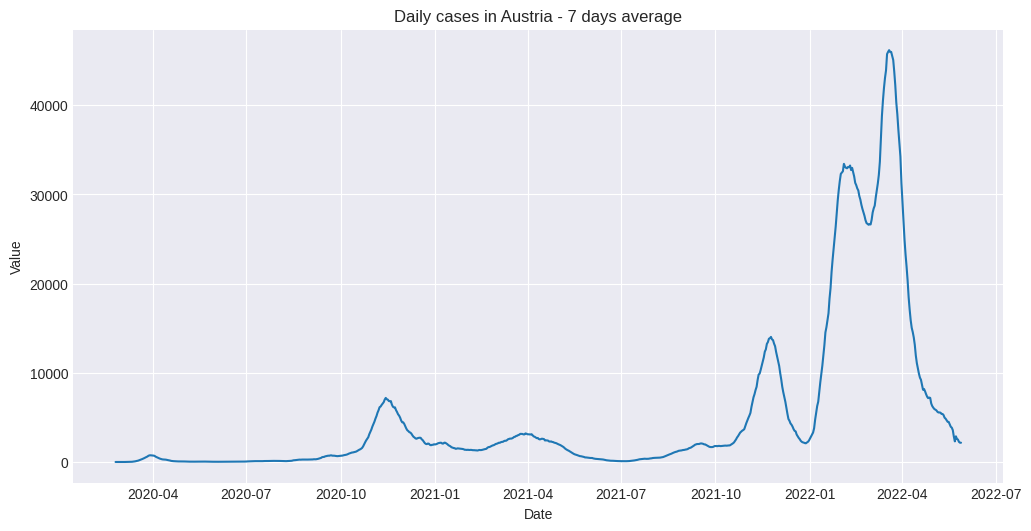

In [78]:
plot_df(df_Austria, x = df_Austria.date, y = df_Austria.ma_cases, title = 'Daily cases in Austria - 7 days average')

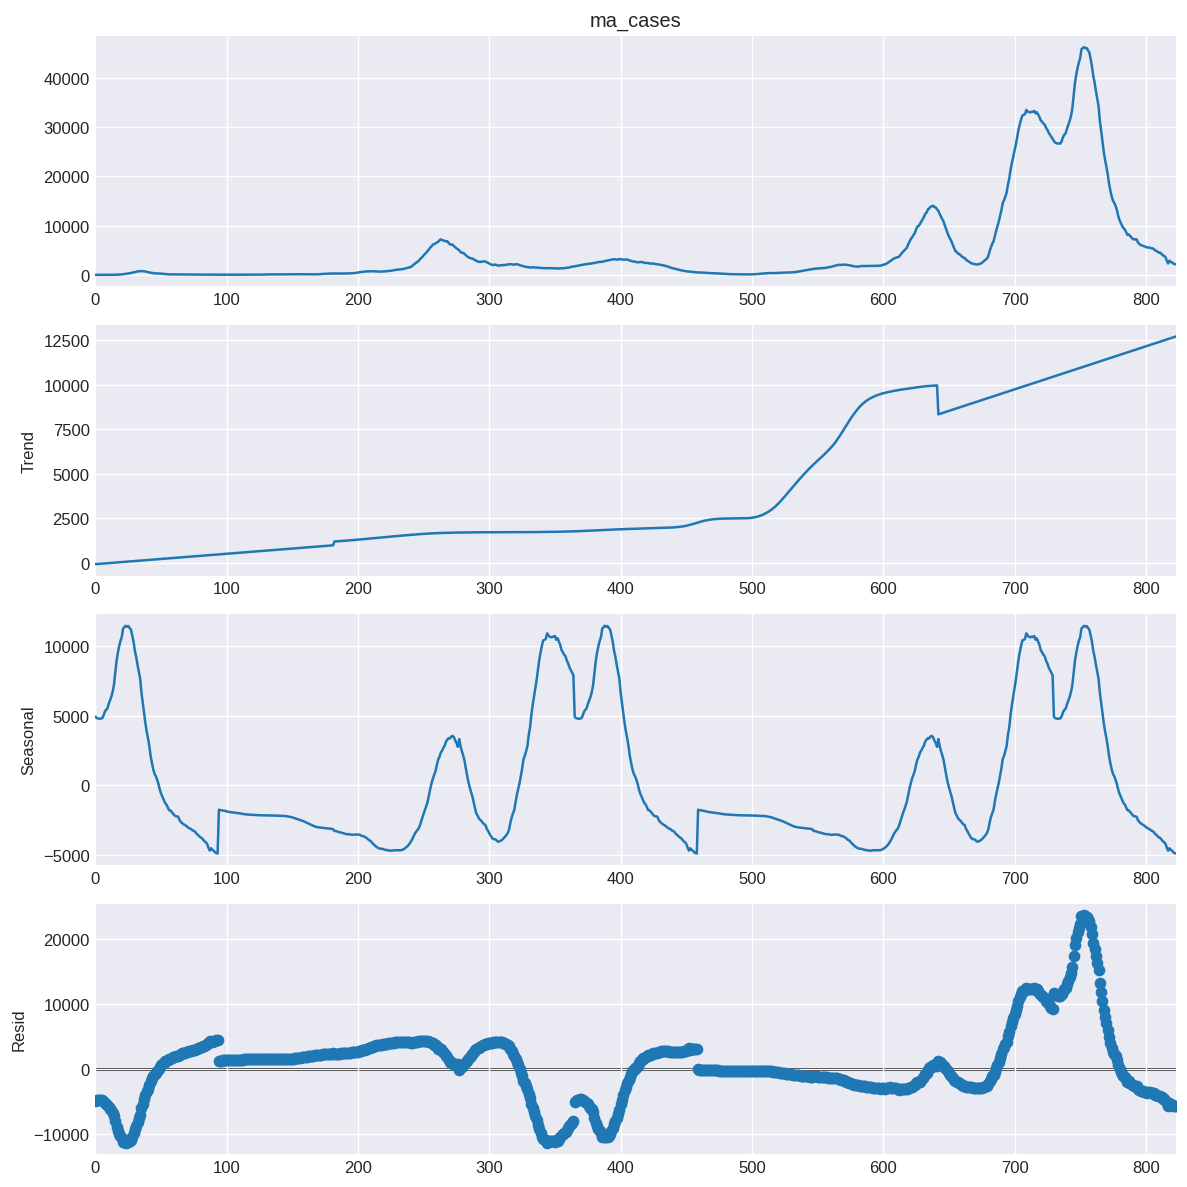

In [79]:
# Additive Decomposition
result_add = seasonal_decompose(df_Austria['ma_cases'], model = 'additive', extrapolate_trend = 'freq', period = 365)

# Plot
plt.rcParams.update({'figure.figsize': (10, 10)})
result_add.plot().suptitle('')
plt.show()

In [80]:
# ADF Test
result = adfuller(df_Austria['ma_cases'].values, autolag = 'AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.0901115974191007
p-value: 0.24850932315345098
Critial Values:
   1%, -3.4384189633001956
Critial Values:
   5%, -2.86510158480911
Critial Values:
   10%, -2.568666500743605


In [81]:
plt.rcParams.update({'figure.figsize': (14, 8), 'figure.dpi': 120})

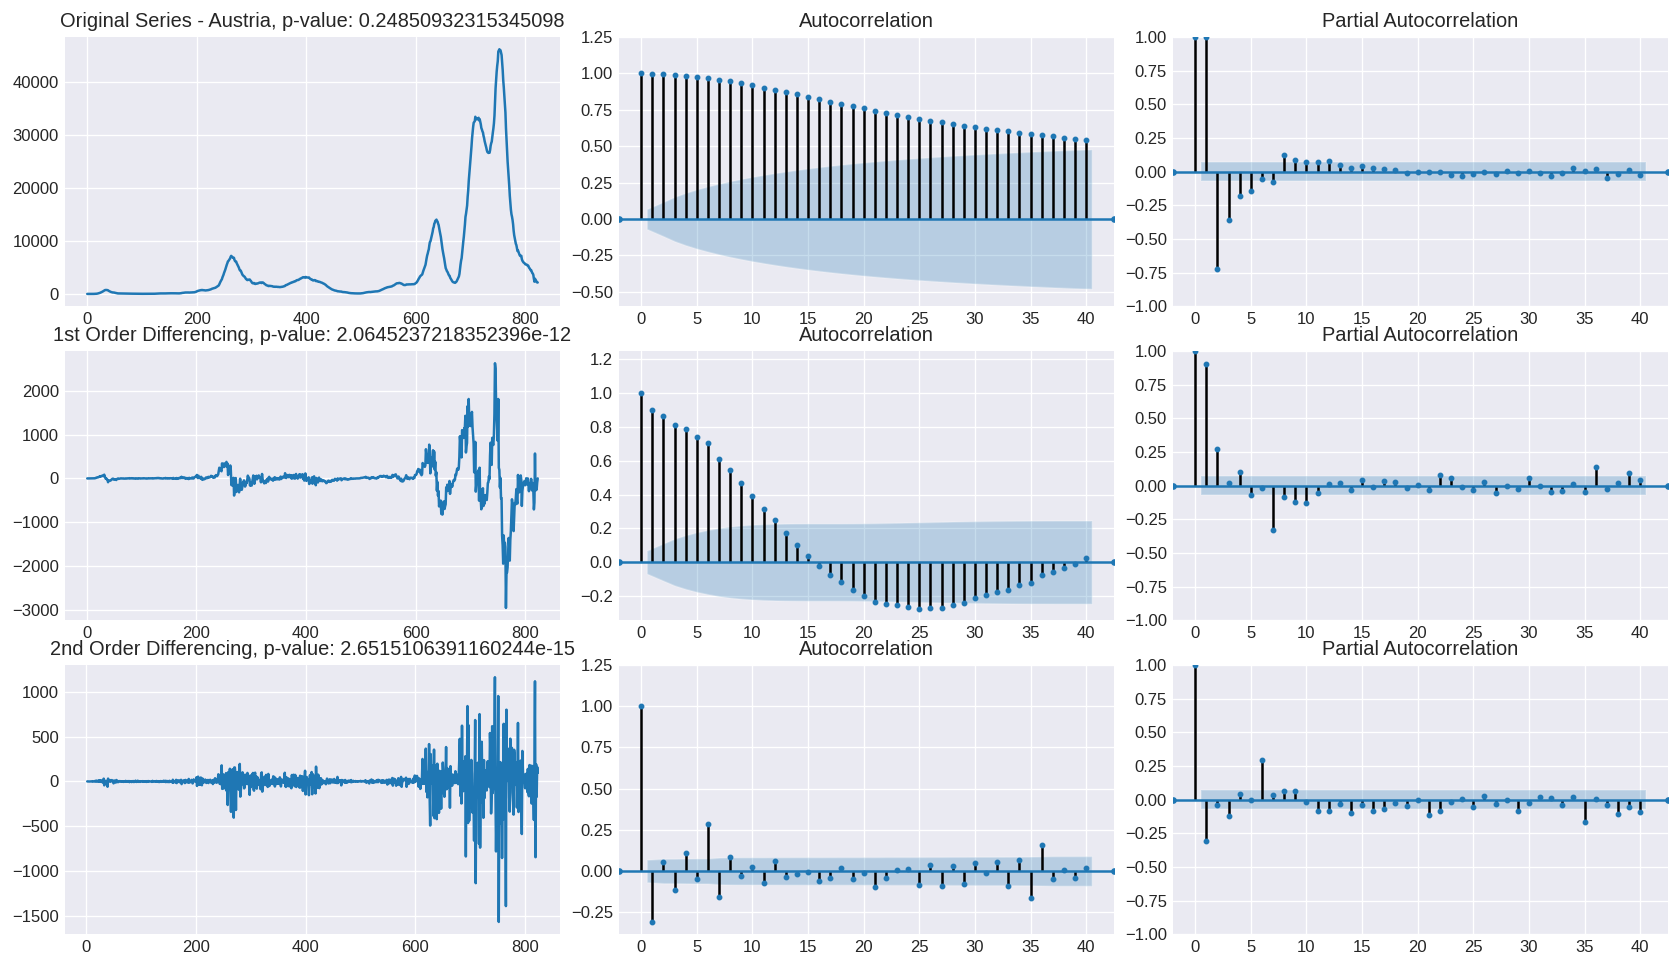

In [82]:
# Original series:
fig, axes = plt.subplots(3, 3)
fig.tight_layout()

axes[0, 0].plot(df_Austria['ma_cases']); axes[0, 0].set_title('Original Series - Austria, p-value: {}'.format(result[1]))
plot_acf(df_Austria['ma_cases'], ax = axes[0, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Austria['ma_cases'], ax = axes[0, 2], lags = 40, marker = '.', method = 'ywm')

# 1st differencing
result1 = adfuller(df_Austria['ma_cases'].diff().dropna().values, autolag = 'AIC')
axes[1, 0].plot(df_Austria['ma_cases'].diff()); axes[1, 0].set_title('1st Order Differencing, p-value: {}'.format(result1[1]))
plot_acf(df_Austria['ma_cases'].diff().dropna(), ax = axes[1, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Austria['ma_cases'].diff().dropna(), ax = axes[1, 2], lags = 40, marker = '.', method = 'ywm')

# 2nd differencing
result2 = adfuller(df_Austria['ma_cases'].diff().diff().dropna().values, autolag = 'AIC')
axes[2, 0].plot(df_Austria['ma_cases'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing, p-value: {}'.format(result2[1]))
plot_acf(df_Austria['ma_cases'].diff().diff().dropna(), ax = axes[2, 1], lags = 40, marker = '.', auto_ylims = True)
plot_pacf(df_Austria['ma_cases'].diff().diff().dropna(), ax = axes[2, 2], lags = 40, marker = '.', method = 'ywm')

plt.show()

In [83]:
# 14, 1, 6 ARIMA Model
model = ARIMA(df_Austria['ma_cases'], order = (7, 1, 6))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:               ma_cases   No. Observations:                  824
Model:                 ARIMA(7, 1, 6)   Log Likelihood               -5347.502
Date:                Sun, 29 May 2022   AIC                          10723.005
Time:                        18:46:09   BIC                          10788.986
Sample:                             0   HQIC                         10748.318
                                - 824                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1876      0.058      3.252      0.001       0.075       0.301
ar.L2          0.6592      0.058     11.271      0.000       0.545       0.774
ar.L3          0.5149      0.047     10.911      0.0

In [84]:
plt.rcParams.update({'figure.figsize':(12, 6), 'figure.dpi':120})

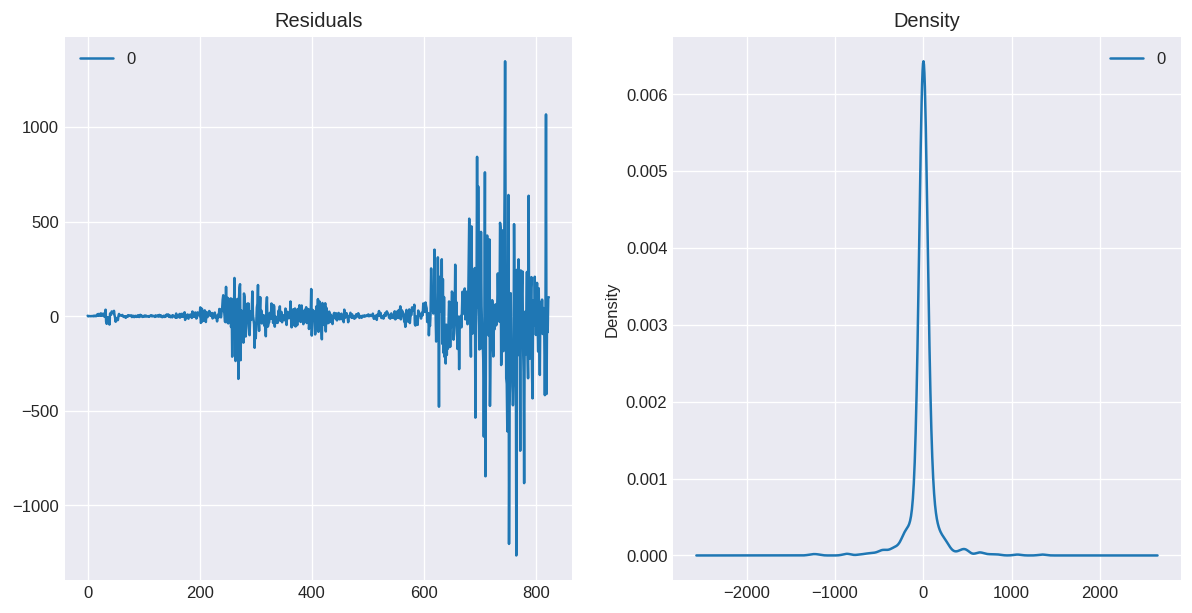

In [85]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)

fig, ax = plt.subplots(1, 2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(kind = 'kde', title = 'Density', ax = ax[1])

plt.show()

In [86]:
# Create Training and Test
train = df_Austria['ma_cases'][ : int(.9 * len(df_Austria))]
test = df_Austria['ma_cases'][int(.9 * len(df_Austria)) :]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


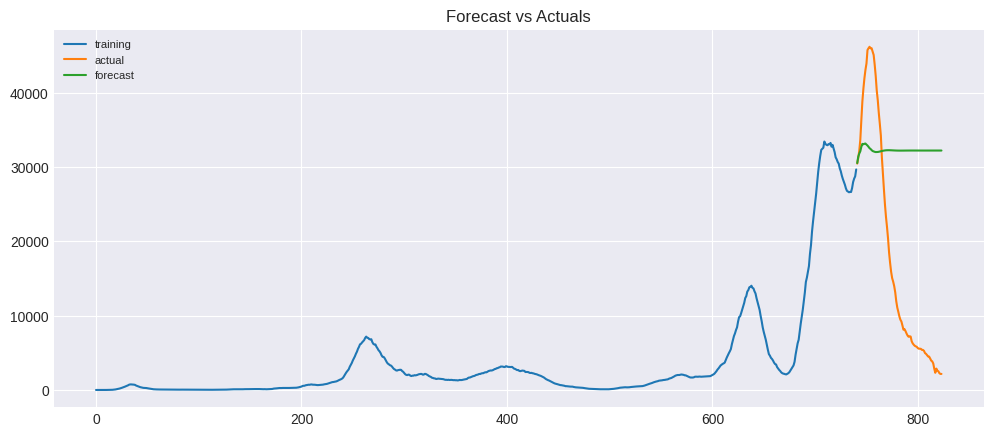

In [87]:
# Build Model 
model = ARIMA(np.log(train), order = (7, 1, 6))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(len(test), alpha = 0.05)  # 95% conf
fc = np.exp(fc)

# Make as pandas series
fc_series = pd.Series(fc, index = test.index)

# Plot
plt.figure(figsize = (12, 5), dpi = 100)
plt.plot(train, label = 'training')
plt.plot(test, label = 'actual')
plt.plot(fc_series, label = 'forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

In [ ]:
print('MSE: ', mean_squared_error(test, fc_series))
print('RMSE: ', np.sqrt(mean_squared_error(test, fc_series)))
print('MAE: ', mean_absolute_error(test, fc_series))
print('MAPE: ', mean_absolute_percentage_error(test, fc_series))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


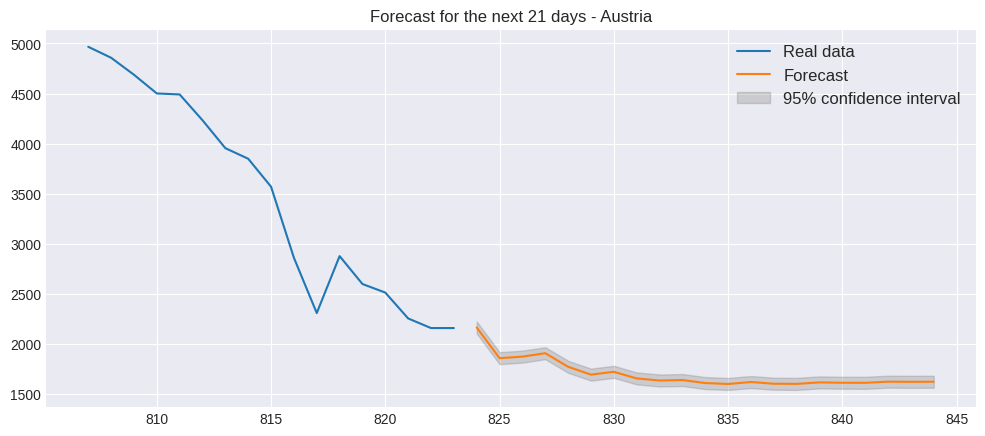

In [89]:
# Build Model
model = ARIMA(np.log(df_Austria['ma_cases']), order = (7, 1, 6))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(21, alpha = 0.05)  # 95% conf
fc = np.exp(fc)
# Make as pandas series
fc_series = pd.Series(fc)

# Plot
plt.figure(figsize = (12, 5), dpi = 100)
plt.plot(df_Austria['ma_cases'][int(0.98 * len(df_Austria)):], label = 'Real data')
plt.plot(fc_series, label = 'Forecast')
ci = 1.96 * np.std(fc_series) / np.sqrt(len(fc_series))
plt.fill_between(fc_series.index, np.array(fc_series - ci), np.array(fc_series + ci), color = 'grey', alpha = .3, label = '95% confidence interval')

plt.title('Forecast for the next 21 days - Austria')
plt.legend(loc = 'upper right', fontsize = 12)
plt.show()

## ARIMA - GARCH models:

### Russia:

In [90]:
# Create Training and Test
train = df_Russia['ma_cases'][ : int(.9 * len(df_Russia))]
test = df_Russia['ma_cases'][int(.9 * len(df_Russia)) :]

In [ ]:
# fit ARIMA on new_cases of Russia 
arima_model = pm.auto_arima(np.log(train))
p, d, q = arima_model.order

arima = ARIMA(np.log(train), order = (p, d, q))
arima_fit = arima.fit()
arima_residuals = np.exp(arima_fit.resid)

In [ ]:
print(p, d, q)

In [93]:
# fit a GARCH(2, 0) model on the residuals of the ARIMA model
garch = ARCH(arima_residuals, vol = 'GARCH', p = 2, q = 0)
garch_fitted = garch.fit()

garch_fitted
garch_fitted.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -1786.8969752371738
Iteration:      2,   Func. Count:     22,   Neg. LLF: 1955.3676630351433
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1241.7337651150733
Iteration:      4,   Func. Count:     35,   Neg. LLF: 313.0512478821834
Iteration:      5,   Func. Count:     42,   Neg. LLF: -40.61964869513356
Iteration:      6,   Func. Count:     49,   Neg. LLF: -91.22168968569096
Iteration:      7,   Func. Count:     56,   Neg. LLF: -332.47788766432865
Iteration:      8,   Func. Count:     65,   Neg. LLF: -352.3443558593291
Iteration:      9,   Func. Count:     74,   Neg. LLF: -352.45177557755545
Iteration:     10,   Func. Count:     81,   Neg. LLF: -388.3147949284866
Iteration:     11,   Func. Count:     93,   Neg. LLF: -390.07514834511375
Iteration:     12,   Func. Count:     99,   Neg. LLF: -2144.4462096668194
Iteration:     13,   Func. Count:    114,   Neg. LLF: -2174.248368314532
Iteration:     14,   Func. Count:    122,   Neg

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                2082.89
Distribution:                  Normal   AIC:                          -4157.78
Method:            Maximum Likelihood   BIC:                          -4139.34
                                        No. Observations:                  742
Date:                Sun, May 29 2022   Df Residuals:                      741
Time:                        18:47:46   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.9993  2.872e-04   3479.392      0.000 [  0.999,  1.000]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.4536e-04  1.124e-05     21.828 1.264e-105 [2.233e-04,2.674e-04]
alpha[1]       0.4855      0.137      3.552  3.830e-04     [  0.218,  0.753]
alpha[2]       0.5145      0.236      2.183  2.901e-02   [5.264e-02,  0.976]
============================================================================

Covariance estimator: robust
"""

In [94]:
# Use ARIMA to predict mu
arima_results = arima_fit.get_prediction(start = len(train) + 1, end = len(df_Russia))
predicted_mu = np.exp(arima_results.predicted_mean)
# predicted_mu

# Use GARCH to predict the residual
garch_result = garch_fitted.forecast(horizon = len(test))
predicted_et = np.exp(garch_result.mean.iloc[-1].values)

# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

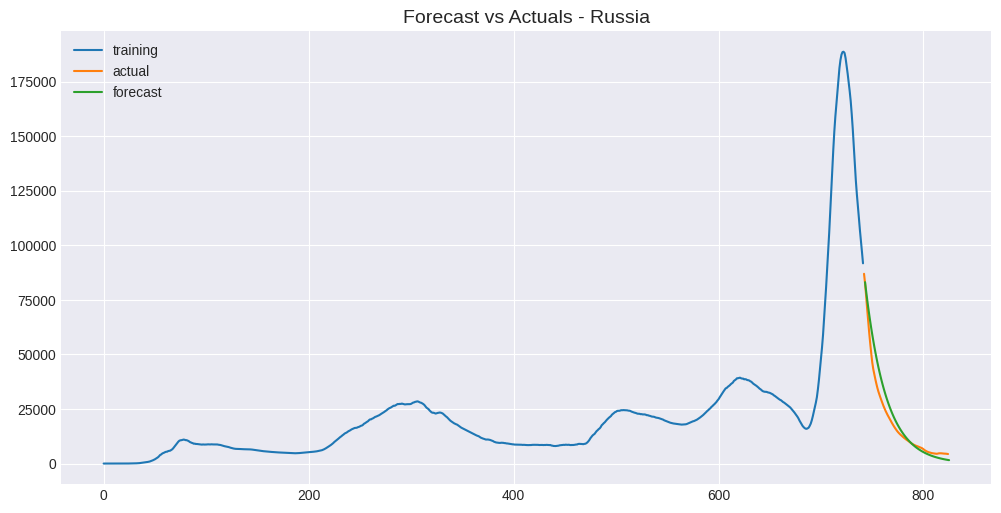

In [95]:
# Plot
plt.figure(figsize = (12, 6), dpi = 100)
plt.plot(train, label = 'training')
plt.plot(test, label = 'actual')
plt.plot(prediction, label = 'forecast')

plt.title('Forecast vs Actuals - Russia', fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 10)
plt.show()

In [ ]:
print('MSE: ', mean_squared_error(test, prediction))
print('RMSE: ', np.sqrt(mean_squared_error(test, prediction)))
print('MAE: ', mean_absolute_error(test, prediction))
print('MAPE: ', mean_absolute_percentage_error(test, prediction))

In [97]:
# p, d, q = 1, 2, 1

arima = ARIMA(np.log(df_Russia['ma_cases'][:-10]), order = (p, d, q))
arima_fit = arima.fit()
arima_residuals = np.exp(arima_fit.resid)

In [ ]:
garch = ARCH(arima_residuals, vol = 'GARCH', p = 2, q = 0)
garch_fitted = garch.fit()

In [99]:
forecast = arima_fit.get_forecast(steps = 10, dynamic = True)
predicted_mu = np.exp(forecast.predicted_mean)
# predicted_mu

# Use GARCH to predict the residual
garch_result = garch_fitted.forecast(horizon = 10)
predicted_et = garch_result.mean.iloc[-1].values

# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

In [ ]:
# Plot
plt.figure(figsize = (12,6), dpi = 100)
plt.plot(df_Russia.ma_cases[-17:], label='actual')
plt.plot(prediction, label='forecast')
plt.title('Forecast - Russia, ARIMA-GARCH', fontsize = 14)
ci = 1.96 * np.std(prediction) / np.sqrt(len(prediction))
plt.fill_between(prediction.index, np.array(prediction - ci), np.array(prediction + ci), color = 'grey', alpha = .3, label = '95% confidence interval')
plt.legend(loc = 'upper right', fontsize = 10)
plt.show()

### Serbia:

In [101]:
# Create Training and Test
train = df_Serbia['ma_cases'][ : int(.9 * len(df_Serbia))]
test = df_Serbia['ma_cases'][int(.9 * len(df_Serbia)) :]

In [ ]:
# fit ARIMA on new_cases of Serbia 
arima_model = pm.auto_arima(np.log(train))
p, d, q = arima_model.order

arima = ARIMA(np.log(train), order = (p, d, q))
arima_fit = arima.fit()
arima_residuals = np.exp(arima_fit.resid)

In [ ]:
print(p, d, q)

In [104]:
# fit a GARCH(1, 0) model on the residuals of the ARIMA model
garch = ARCH(arima_residuals, vol = 'GARCH', p = 1, q = 0)
garch_fitted = garch.fit()

garch_fitted
garch_fitted.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -217.24102470515163
Iteration:      2,   Func. Count:     14,   Neg. LLF: -218.17654395467588
Iteration:      3,   Func. Count:     23,   Neg. LLF: -276.21203660297834
Iteration:      4,   Func. Count:     29,   Neg. LLF: -276.84684814946354
Iteration:      5,   Func. Count:     36,   Neg. LLF: -277.16325761856865
Iteration:      6,   Func. Count:     42,   Neg. LLF: -277.8159290421987
Iteration:      7,   Func. Count:     47,   Neg. LLF: -278.4412236753394
Iteration:      8,   Func. Count:     52,   Neg. LLF: -278.5342538491669
Iteration:      9,   Func. Count:     57,   Neg. LLF: -278.5475169237094
Iteration:     10,   Func. Count:     62,   Neg. LLF: -278.5476485592281
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -278.54764929996554
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                278.548
Distribution:                  Normal   AIC:                          -551.095
Method:            Maximum Likelihood   BIC:                          -537.308
                                        No. Observations:                  732
Date:                Sun, May 29 2022   Df Residuals:                      731
Time:                        18:50:56   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.0043  6.065e-03    165.588      0.000 [  0.992,  1.016]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0261  2.249e-02      1.162      0.245 [-1.795e-02,7.023e-02]
alpha[1]       0.2067      0.110      1.877  6.057e-02   [-9.181e-03,  0.423]
=============================================================================

Covariance estimator: robust
"""

In [106]:
# Use ARIMA to predict mu
arima_results = arima_fit.get_prediction(start = len(train) + 1, end = len(df_Serbia))
predicted_mu = np.exp(arima_results.predicted_mean)
# predicted_mu

# Use GARCH to predict the residual
garch_result = garch_fitted.forecast(horizon = len(test))
predicted_et = np.exp(garch_result.mean.iloc[-1].values)

# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

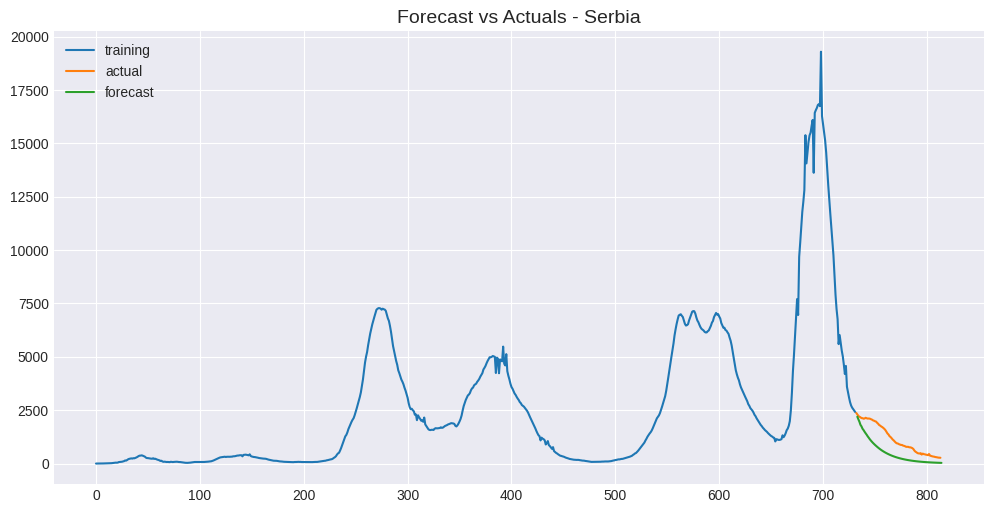

In [107]:
# Plot
plt.figure(figsize = (12, 6), dpi = 100)
plt.plot(train, label = 'training')
plt.plot(test, label = 'actual')
plt.plot(prediction, label = 'forecast')

plt.title('Forecast vs Actuals - Serbia', fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 10)
plt.show()

In [ ]:
print('MSE: ', mean_squared_error(test, prediction))
print('RMSE: ', np.sqrt(mean_squared_error(test, prediction)))
print('MAE: ', mean_absolute_error(test, prediction))
print('MAPE: ', mean_absolute_percentage_error(test, prediction))

In [ ]:
arima = ARIMA(np.log(df_Serbia['ma_cases'][:-10]), order = (p, d, q))
arima_fit = arima.fit()
arima_residuals = np.exp(arima_fit.resid)

In [ ]:
garch = ARCH(arima_residuals, vol = 'GARCH', p = 1, q = 0)
garch_fitted = garch.fit()

In [111]:
forecast = arima_fit.get_forecast(steps = 10, dynamic = True)
predicted_mu = np.exp(forecast.predicted_mean)
# predicted_mu

# Use GARCH to predict the residual
garch_result = garch_fitted.forecast(horizon = 10)
predicted_et = garch_result.mean.iloc[-1].values

# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

In [ ]:
prediction

In [ ]:
df_Serbia['ma_cases'][-10:]

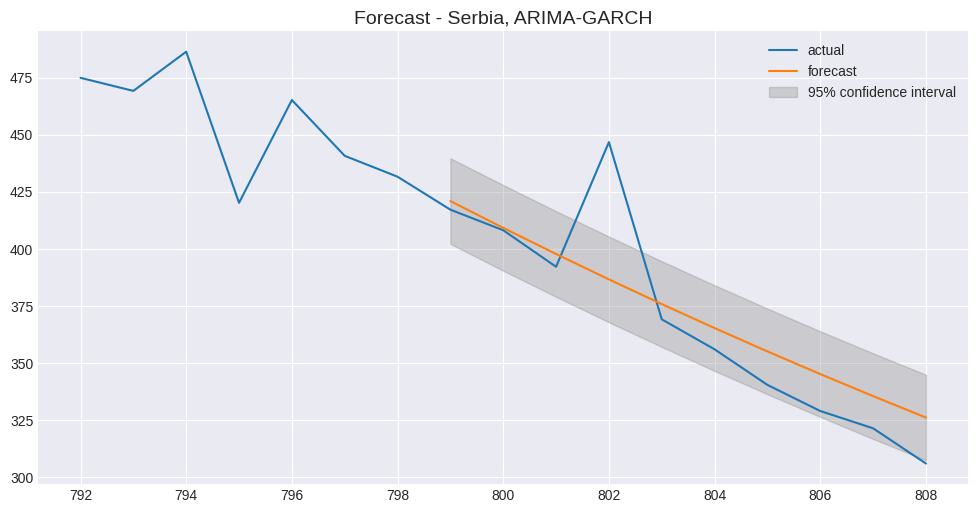

In [ ]:
# Plot
plt.figure(figsize = (12,6), dpi = 100)
plt.plot(df_Serbia.ma_cases[-17:], label = 'actual')
plt.plot(prediction, label = 'forecast')
plt.title('Forecast - Serbia, ARIMA-GARCH', fontsize = 14)
ci = 1.96 * np.std(prediction) / np.sqrt(len(prediction))
plt.fill_between(prediction.index, np.array(prediction - ci), np.array(prediction + ci), color = 'grey', alpha = .3, label = '95% confidence interval')
plt.legend(loc = 'upper right', fontsize = 10)
plt.show()

### Sweden:

In [ ]:
# Create Training and Test
train = df_Sweden['ma_cases'][ : int(.9 * len(df_Sweden))]
test = df_Sweden['ma_cases'][int(.9 * len(df_Sweden)) :]

In [ ]:
# fit ARIMA on new_cases of Sweden 
arima_model = pm.auto_arima(np.log(train))
p, d, q = arima_model.order

arima = ARIMA(np.log(train), order = (p, d, q))
arima_fit = arima.fit()
arima_residuals = np.exp(arima_fit.resid)

In [ ]:
print(len(arima_residuals))
print(p, d, q)

In [ ]:
# fit a GARCH(1,0) model on the residuals of the ARIMA model
garch = ARCH(arima_residuals, vol = 'GARCH', p = 1, q = 0)
garch_fitted = garch.fit()

garch_fitted
garch_fitted.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1461.2832515045561
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1452.0156657986306
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1443.6663303811877
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1363.663710474615
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1347.4139326626516
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1307.4587383805265
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1287.6864215495862
Iteration:      8,   Func. Count:     54,   Neg. LLF: 1268.797140319293
Iteration:      9,   Func. Count:     60,   Neg. LLF: 1251.151386808048
Iteration:     10,   Func. Count:     66,   Neg. LLF: 1234.8853537245736
Iteration:     11,   Func. Count:     72,   Neg. LLF: 1218.5966590604694
Iteration:     12,   Func. Count:     78,   Neg. LLF: 1204.8062704887298
Iteration:     13,   Func. Count:     84,   Neg. LLF: 1193.143726360032
Iteration:     14,   Func. Count:     90,   Neg. LLF: 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1156.47
Distribution:                  Normal   AIC:                           2318.95
Method:            Maximum Likelihood   BIC:                           2332.74
                                        No. Observations:                  733
Date:                Tue, May 24 2022   Df Residuals:                      732
Time:                        09:41:12   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            10.0536  5.592e-02    179.771      0.000 [  9.944, 10.163]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6865      0.137      5.015  5.307e-07 [  0.418,  0.955]
alpha[1]       1.0000      0.343      2.913  3.577e-03 [  0.327,  1.673]
========================================================================

Covariance estimator: robust
"""

In [ ]:
# Use ARIMA to predict mu
arima_results = arima_fit.get_prediction(start = len(train) + 1, end = len(df_Sweden))
predicted_mu = np.exp(arima_results.predicted_mean)
# predicted_mu

# Use GARCH to predict the residual
garch_result = garch_fitted.forecast(horizon = len(test)) 
predicted_et = np.exp(garch_result.mean.iloc[-1].values)

# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

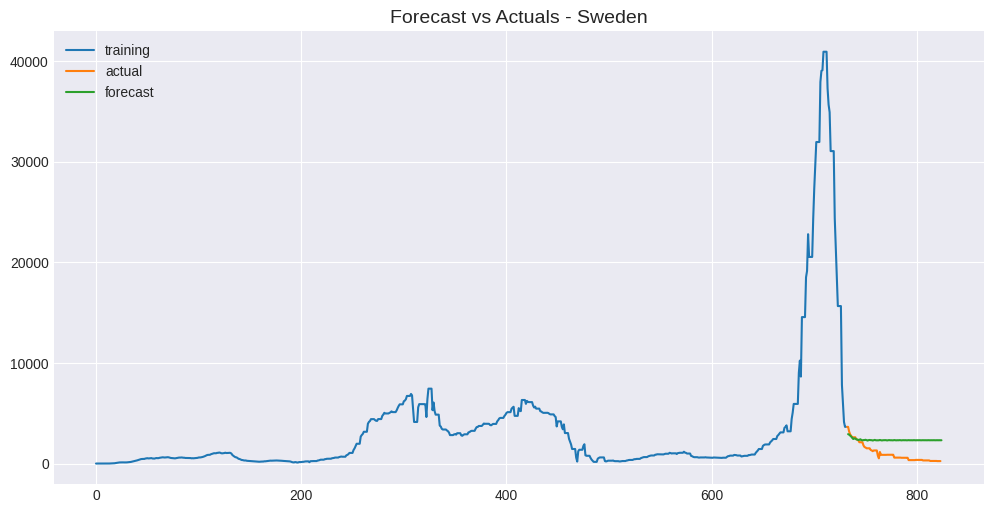

In [ ]:
# Plot
plt.figure(figsize = (12,6), dpi = 100)
plt.plot(train, label = 'training')
plt.plot(test, label = 'actual')
plt.plot(prediction, label = 'forecast')
plt.title('Forecast vs Actuals - Sweden', fontsize = 14)
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [ ]:
print('MSE: ', mean_squared_error(test, prediction))
print('RMSE: ', np.sqrt(mean_squared_error(test, prediction)))
print('MAE: ', mean_absolute_error(test, prediction))
print('MAPE: ', mean_absolute_percentage_error(test, prediction))

In [ ]:
arima = ARIMA(np.log(df_Sweden['ma_cases'][:-10]), order = (p, d, q))
arima_fit = arima.fit()
arima_residuals = np.exp(arima_fit.resid)

In [ ]:
garch = ARCH(arima_residuals, vol = 'GARCH', p = 1, q = 0)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -145.13545429641306
Iteration:      2,   Func. Count:     15,   Neg. LLF: -145.36020891456627
Iteration:      3,   Func. Count:     21,   Neg. LLF: -216.59987044538394
Iteration:      4,   Func. Count:     27,   Neg. LLF: -240.93047944986958
Iteration:      5,   Func. Count:     33,   Neg. LLF: -269.074363791147
Iteration:      6,   Func. Count:     39,   Neg. LLF: -290.794799072025
Iteration:      7,   Func. Count:     45,   Neg. LLF: -315.35556714806444
Iteration:      8,   Func. Count:     51,   Neg. LLF: -331.12633087083
Iteration:      9,   Func. Count:     56,   Neg. LLF: -365.7871098188631
Iteration:     10,   Func. Count:     62,   Neg. LLF: -383.10946356018485
Iteration:     11,   Func. Count:     68,   Neg. LLF: -402.29857081551717
Iteration:     12,   Func. Count:     74,   Neg. LLF: -416.99315515726374
Iteration:     13,   Func. Count:     80,   Neg. LLF: -428.92008662238214
Iteration:     14,   Func. Count:     86,   Ne

In [ ]:
forecast = arima_fit.get_forecast(steps = 10, dynamic = True)
predicted_mu = np.exp(forecast.predicted_mean)
# predicted_mu

# Use GARCH to predict the residual
garch_result = garch_fitted.forecast(horizon = 10)
predicted_et = garch_result.mean.iloc[-1].values

# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

In [ ]:
df_Sweden.ma_cases[-10:]

In [ ]:
prediction

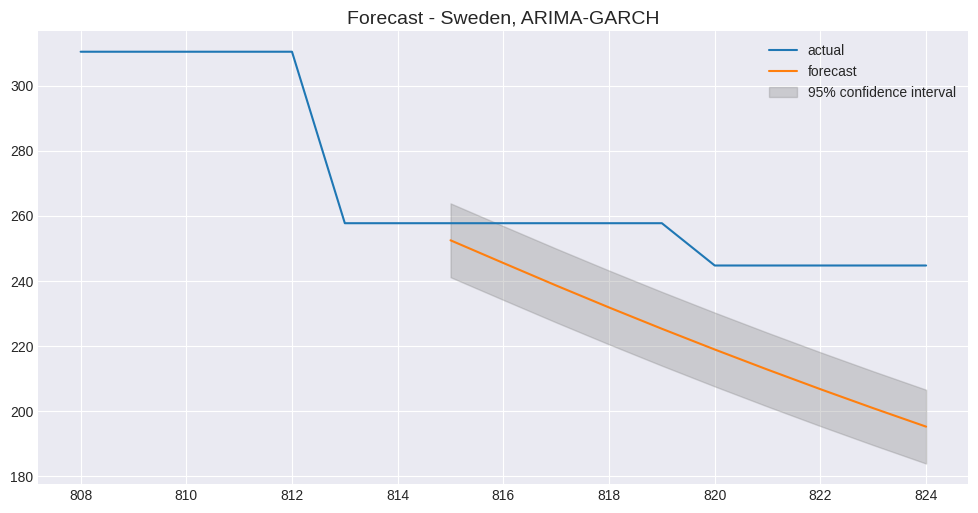

In [ ]:
# Plot
plt.figure(figsize = (12,6), dpi = 100)
plt.plot(df_Sweden.ma_cases[-17:], label='actual')
plt.plot(prediction, label='forecast')
plt.title('Forecast - Sweden, ARIMA-GARCH', fontsize = 14)
ci = 1.96 * np.std(prediction) / np.sqrt(len(prediction))
plt.fill_between(prediction.index, np.array(prediction - ci), np.array(prediction + ci), color = 'grey', alpha = .3, label = '95% confidence interval')
plt.legend(loc = 'upper right', fontsize = 10)
plt.show()

### Italy:

In [ ]:
# Create Training and Test
train = df_Italy['ma_cases'][ : int(.9 * len(df_Italy))]
test = df_Italy['ma_cases'][int(.9 * len(df_Italy)) :]

In [ ]:
# fit ARIMA on new_cases of Italy 
arima_model = pm.auto_arima(np.log(train))
p, d, q = arima_model.order

arima = ARIMA(np.log(train), order = (p, d, q))
arima_fit = arima.fit()
arima_residuals = np.exp(arima_fit.resid)

In [ ]:
print(len(arima_residuals))
print(p, d, q)

In [ ]:
# fit a GARCH(1,0) model on the residuals of the ARIMA model
garch = ARCH(arima_residuals, vol = 'GARCH', p = 1, q = 0)
garch_fitted = garch.fit()

garch_fitted
garch_fitted.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 732.4075103227499
Iteration:      2,   Func. Count:     14,   Neg. LLF: 666.3380743483015
Iteration:      3,   Func. Count:     22,   Neg. LLF: 645.3473954766504
Iteration:      4,   Func. Count:     27,   Neg. LLF: 620.165782493426
Iteration:      5,   Func. Count:     32,   Neg. LLF: 617.9593715952126
Iteration:      6,   Func. Count:     37,   Neg. LLF: 617.6010315816294
Iteration:      7,   Func. Count:     42,   Neg. LLF: 617.5721457978966
Iteration:      8,   Func. Count:     47,   Neg. LLF: 617.5717176148248
Iteration:      9,   Func. Count:     52,   Neg. LLF: 617.5717001036096
Iteration:     10,   Func. Count:     57,   Neg. LLF: 617.5716855496106
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 617.5716803414202
            Iterations: 11
            Function evaluations: 61
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -617.572
Distribution:                  Normal   AIC:                           1241.14
Method:            Maximum Likelihood   BIC:                           1254.98
                                        No. Observations:                  744
Date:                Tue, May 24 2022   Df Residuals:                      743
Time:                        09:46:44   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.0229  2.043e-02     50.061      0.000 [  0.983,  1.063]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.3080      0.304      1.014      0.310      [ -0.287,  0.903]
alpha[1]   3.9194e-09  1.794e-03  2.185e-06      1.000 [-3.515e-03,3.515e-03]
=============================================================================

Covariance estimator: robust
"""

In [ ]:
# Use ARIMA to predict mu
arima_results = arima_fit.get_prediction(start = len(train) + 1, end = len(df_Italy))
predicted_mu = np.exp(arima_results.predicted_mean)
# predicted_mu

# Use GARCH to predict the residual
garch_result = garch_fitted.forecast(horizon = len(test)) 
predicted_et = np.exp(garch_result.mean.iloc[-1].values)

# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

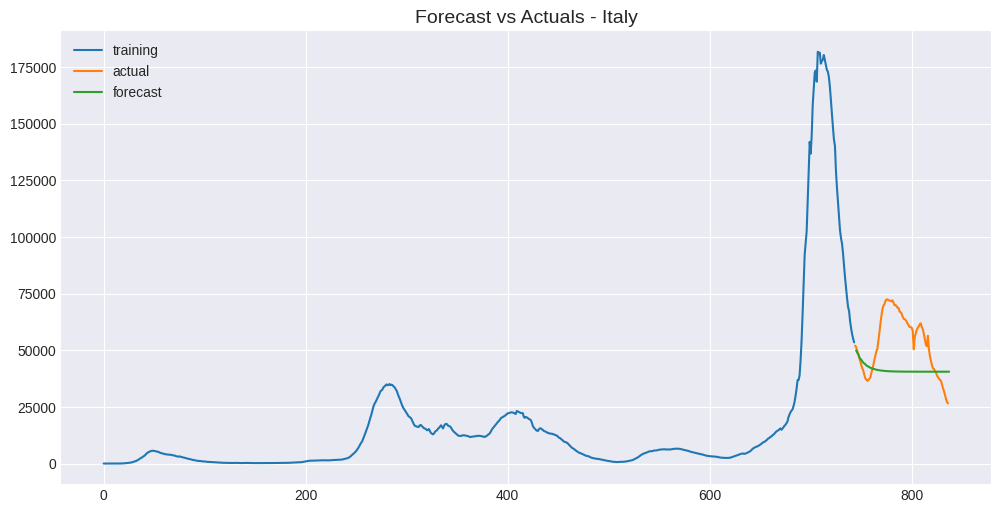

In [ ]:
# Plot
plt.figure(figsize = (12,6), dpi = 100)
plt.plot(train, label = 'training')
plt.plot(test, label = 'actual')
plt.plot(prediction, label = 'forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color = 'k', alpha = .15)
plt.title('Forecast vs Actuals - Italy', fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 10)
plt.show()

In [ ]:
print('MSE: ', mean_squared_error(test, prediction))
print('RMSE: ', np.sqrt(mean_squared_error(test, prediction)))
print('MAE: ', mean_absolute_error(test, prediction))
print('MAPE: ', mean_absolute_percentage_error(test, prediction))

In [ ]:
arima = ARIMA(np.log(df_Italy['ma_cases'][:-10]), order = (p, d, q))
arima_fit = arima.fit()
arima_residuals = np.exp(arima_fit.resid)

In [ ]:
garch = ARCH(arima_residuals, vol = 'GARCH', p = 1, q = 0)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 763.9206522427083
Iteration:      2,   Func. Count:     13,   Neg. LLF: 747.620890176915
Iteration:      3,   Func. Count:     21,   Neg. LLF: 679.5339410281591
Iteration:      4,   Func. Count:     27,   Neg. LLF: 650.3296544880604
Iteration:      5,   Func. Count:     32,   Neg. LLF: 642.0723965465696
Iteration:      6,   Func. Count:     37,   Neg. LLF: 641.3046833990154
Iteration:      7,   Func. Count:     42,   Neg. LLF: 638.0644018195146
Iteration:      8,   Func. Count:     47,   Neg. LLF: 636.6871996180453
Iteration:      9,   Func. Count:     52,   Neg. LLF: 636.4959256075812
Iteration:     10,   Func. Count:     57,   Neg. LLF: 636.4879980447548
Iteration:     11,   Func. Count:     66,   Neg. LLF: 636.4879194583385
Iteration:     12,   Func. Count:     75,   Neg. LLF: 636.4879168642843
Iteration:     13,   Func. Count:     80,   Neg. LLF: 636.4870415310673
Optimization terminated successfully.    (Exit mode 0)
          

In [ ]:
forecast = arima_fit.get_forecast(steps = 10, dynamic = True)
predicted_mu = np.exp(forecast.predicted_mean)
# predicted_mu
# Use GARCH to predict the residual
garch_result = garch_fitted.forecast(horizon = 10)
predicted_et = garch_result.mean.iloc[-1].values
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

In [ ]:
prediction

In [ ]:
df_Italy['ma_cases'][-10:]

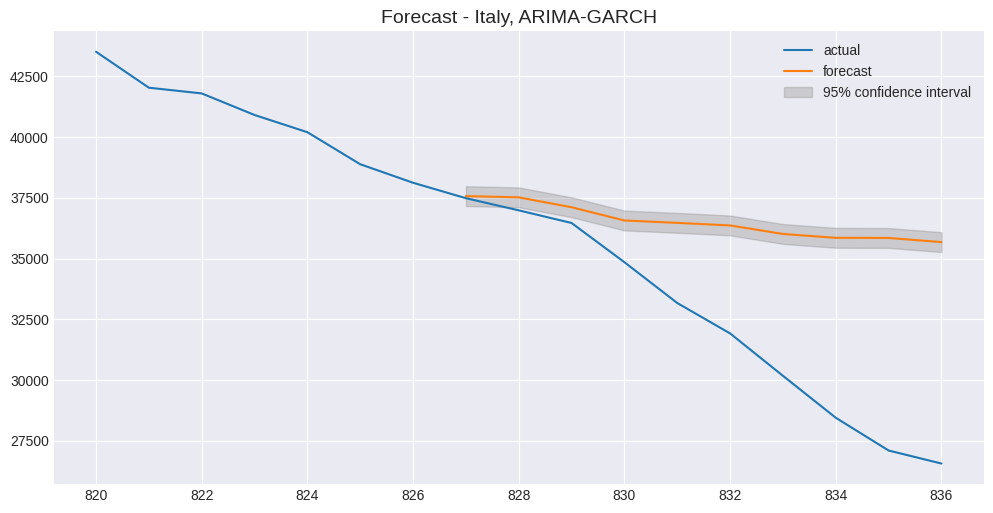

In [ ]:
# Plot
plt.figure(figsize = (12,6), dpi = 100)
# plt.plot(train, label = 'training')
plt.plot(df_Italy['ma_cases'][-17:], label = 'actual')
plt.plot(prediction, label = 'forecast')
plt.title('Forecast - Italy, ARIMA-GARCH', fontsize = 14)
ci = 1.96 * np.std(prediction) / np.sqrt(len(prediction))
plt.fill_between(prediction.index, np.array(prediction - ci), np.array(prediction + ci), color = 'grey', alpha = .3, label = '95% confidence interval')
plt.legend(loc = 'upper right', fontsize = 10)
plt.show()

### Austria:

In [ ]:
# Create Training and Test
train = df_Austria['ma_cases'][ : int(.9 * len(df_Austria))]
test = df_Austria['ma_cases'][int(.9 * len(df_Austria)) :]

In [ ]:
# fit ARIMA on new_cases of Italy 
arima_model = pm.auto_arima(np.log(train))
p, d, q = arima_model.order

arima = ARIMA(np.log(train), order = (p, d, q))
arima_fit = arima.fit()
arima_residuals = np.exp(arima_fit.resid)

In [ ]:
print(len(arima_residuals))
print(p, d, q)

In [ ]:
# fit a GARCH(1,0) model on the residuals of the ARIMA model
garch = ARCH(arima_residuals, vol = 'GARCH', p = 1, q = 0)
garch_fitted = garch.fit()

garch_fitted
garch_fitted.summary()

In [ ]:
# Use ARIMA to predict mu
arima_results = arima_fit.get_prediction(start = len(train) + 1, end = len(df_Austria))
# arima_results = arima_model.forecast(horizon = len(test))
predicted_mu = np.exp(arima_results.predicted_mean)
# predicted_mu
# Use GARCH to predict the residual
garch_result = garch_fitted.forecast(horizon = len(test)) 
predicted_et = np.exp(garch_result.mean.iloc[-1].values)
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

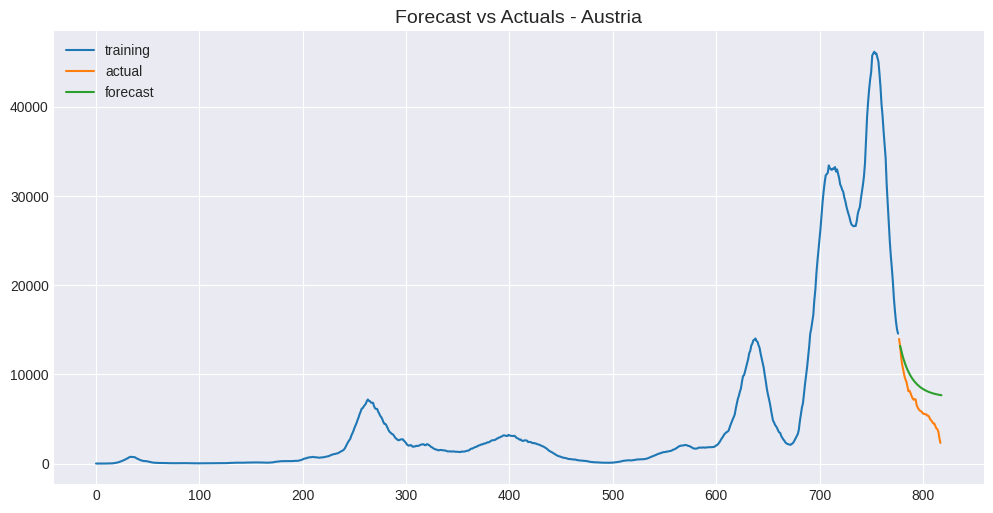

In [ ]:
# Plot
plt.figure(figsize = (12,6), dpi = 100)
plt.plot(train, label = 'training')
plt.plot(test, label = 'actual')
plt.plot(prediction, label = 'forecast')

plt.title('Forecast vs Actuals - Austria', fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 10)
plt.show()

In [ ]:
print('MSE: ', mean_squared_error(test, prediction))
print('RMSE: ', np.sqrt(mean_squared_error(test, prediction)))
print('MAE: ', mean_absolute_error(test, prediction))
print('MAPE: ', mean_absolute_percentage_error(test, prediction))

In [ ]:
arima = ARIMA(np.log(df_Austria['ma_cases'][:-10]), order = (p, d, q))
arima_fit = arima.fit()
arima_residuals = np.exp(arima_fit.resid)

In [ ]:
garch = ARCH(arima_residuals, vol = 'GARCH', p = 1, q = 0)
garch_fitted = garch.fit()

In [ ]:
forecast = arima_fit.get_forecast(steps = 10, dynamic = True)
predicted_mu = np.exp(forecast.predicted_mean)
# predicted_mu
# Use GARCH to predict the residual
garch_result = garch_fitted.forecast(horizon = 10)
predicted_et = garch_result.mean.iloc[-1].values
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

In [ ]:
prediction

In [ ]:
df_Austria['ma_cases'][-10:]

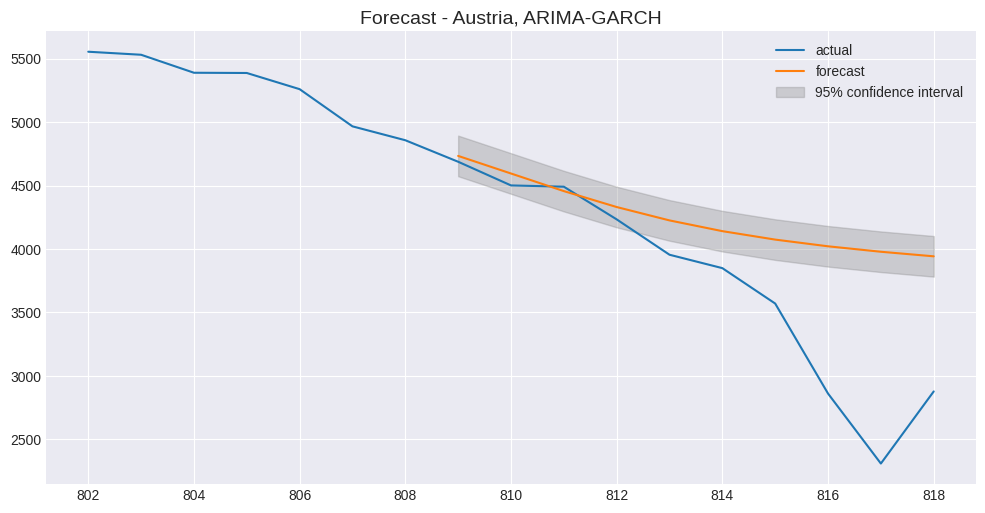

In [ ]:
# Plot
plt.figure(figsize = (12,6), dpi = 100)
# plt.plot(train, label = 'training')
plt.plot(df_Austria['ma_cases'][-17:], label = 'actual')
plt.plot(prediction, label = 'forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color = 'k', alpha = .15)
plt.title('Forecast - Austria, ARIMA-GARCH', fontsize = 14)
ci = 1.96 * np.std(prediction) / np.sqrt(len(prediction))
plt.fill_between(prediction.index, np.array(prediction - ci), np.array(prediction + ci), color = 'grey', alpha = .3, label = '95% confidence interval')
plt.legend(loc = 'upper right', fontsize = 10)
plt.show()